# ANLP Assignment 2: Text Generation
### Shuying Piao,  id: a1912828

## Table of Contents
1.	Reading dataset and initial pre-processing
2.	Exploratory Data Analysis (EDA)
3.	Selection and training Machine Learning models
      - 3.1 Model-Oriented Data Preprocessing
      - 3.2 Define evaluation metric functions
4.	Model Fine-Tuning and Hyperparameter Selection (T5 and GPT-2)
      - 4.1 T5-Small model
      - 4.2 GPT-2 model
      - 4.3 Validation-Based Evaluation and Model Selection
5.	Final Model Selection and Test Set Evaluation
6.	User Interface Implementation
7.	References
8.	Appendix
   - Comparison of the model architectures between T5-small and GPT-2
   - Outcomes of the User Interface Implementation

In [1]:
import os
import re
import pandas as pd
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import gensim.downloader as api
from transformers import T5Tokenizer, T5TokenizerFast, T5ForConditionalGeneration, GPT2Tokenizer, GPT2LMHeadModel, get_scheduler
from bert_score import score
from rouge_score import rouge_scorer
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from sklearn.model_selection import train_test_split


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/opt/conda/Anaconda3/envs/nlp-small/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda:0


# 1. Reading dataset and initial pre-processing

In [2]:
# Load and process a single dataset (train or test): expand 'ratings', retain other fields, and set 'review_id' as index.
def prepare_dataset(data_path):
    df = pd.read_json(data_path, lines=True)
    df = df.rename(columns={'id': 'review_id'})
    
    ratings_df = df['ratings'].apply(pd.Series)
    extra_columns = [col for col in df.columns if col not in ['text', 'title', 'ratings']]
    
    processed_df = pd.concat([ratings_df, df[extra_columns],df[['text']]], axis=1)
    processed_df = processed_df.set_index('review_id')
    
    return processed_df

In [3]:
train_df= prepare_dataset('hotel_reviews_train.JSON')
test_df= prepare_dataset('hotel_reviews_test.JSON')
train_df.head(3)

,service,cleanliness,overall,value,location,sleep_quality,rooms,check_in_front_desk,business_service_(e_g_internet_access),author,date_stayed,offering_id,num_helpful_votes,date,via_mobile,text
review_id,,,,,,,,,,,,,,,,
140716137,1.0,2.0,1.0,1.0,3.0,2.0,1.0,NaN,NaN,"{'username': 'Kh3RD', 'num_reviews': 1, 'id': ...",September 2012,80138,0,2012-09-19,False,First of all we got there and they didn't have...
114807323,1.0,1.0,1.0,2.0,NaN,1.0,NaN,NaN,NaN,"{'username': 'TheUglyPhotographer', 'num_citie...",June 2011,240151,1,2011-06-27,False,Found Racist graffiti in the room. Request to ...
84805430,4.0,5.0,4.0,3.0,5.0,4.0,4.0,NaN,NaN,"{'username': 'Moonstonemoclips', 'num_cities':...",October 2010,80793,0,2010-10-25,False,Close to Union Square - hotel is a bit of a ma...


In [4]:
# View basic info of the training set: column data types, non-null counts
print("\nTrain Data Info:")
train_df.info()

# View basic info of the test set: column data types, non-null counts
print("\nTest Data Info:")
test_df.info()


Train Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 24000 entries, 140716137 to 145539000
Data columns (total 16 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   service                                 21550 non-null  float64       
 1   cleanliness                             21545 non-null  float64       
 2   overall                                 24000 non-null  float64       
 3   value                                   21547 non-null  float64       
 4   location                                18983 non-null  float64       
 5   sleep_quality                           14185 non-null  float64       
 6   rooms                                   20000 non-null  float64       
 7   check_in_front_desk                     2909 non-null   float64       
 8   business_service_(e_g_internet_access)  1959 non-null   float64       
 9   author                   

In [5]:
# Define a cleaning function for the target review text

def clean_text_for_generation(text):
    if not isinstance(text, str):
        return ""
    
    text = text.lower()  # Convert to lowercase for easier word vector matching
    text = re.sub(r'<.*?>', '', text)  # Remove any HTML tags
    text = re.sub(r'[^\x00-\x7F]+', '', text)   # Remove non-ASCII characters (emoji, non-English characters)
    text = re.sub(r'[^a-z0-9.,!?\'\";:\-\s]', '', text)  #keep English chars & punctuation
    text = re.sub(r'\s+', ' ', text)  # Normalize whitespace by replacing multiple spaces with a single space
    return text.strip()


train_df['text'] = train_df['text'].apply(clean_text_for_generation)
test_df['text'] = test_df['text'].apply(clean_text_for_generation)

根据本次作业的核心任务，即通过整体评分（overall rating）和各方面评分（aspect numerical ratings）预测客户评论文本（customer’s review），本阶段首先将 ratings 字段展开为单独的评分维度，以便后续的可视化分析（EDA）和模型输入的结构化准备。

除了评分信息外，我保留了其余的元数据字段（如 author、date_stayed、offering_id 等），因为这些字段可能为模型生成评论提供有价值的上下文线索。考虑到部分样本存在缺失值，我选择在构造输入 prompt 时动态跳过缺失字段，而非直接删除数据，以最大程度保留用户提供的有效信息，避免不必要的信息损失。

此外，为了提升模型在文本生成阶段的质量与一致性，我对评论文本字段 text 进行了规范化处理。该清洗步骤包括统一为小写、去除非 ASCII 字符、HTML 标签及冗余空格等，以确保生成目标更加干净且具备一致性，利于模型学习。

Given that the core task of this assignment is to predict a customer’s review based on the overall rating and aspect-level numerical ratings, the first step in this phase is to expand the ratings field into separate rating dimensions. This facilitates both exploratory data analysis (EDA) and structured model input.

In addition to the ratings, I retained all other metadata fields (such as author, date_stayed, offering_id, etc.), as they may provide meaningful contextual signals for the generation task. Rather than removing records with missing values, I chose to dynamically skip missing fields during input prompt construction. This approach preserves as much useful information as possible while avoiding unnecessary data loss.

To further improve the consistency and quality of the review generation task, I applied text normalization to the text field. The cleaning process includes converting text to lowercase, removing non-ASCII characters, HTML tags, and redundant spaces. This ensures a cleaner and more consistent target output for training the model effectively.

# 2. Exploratory Data Analysis (EDA)

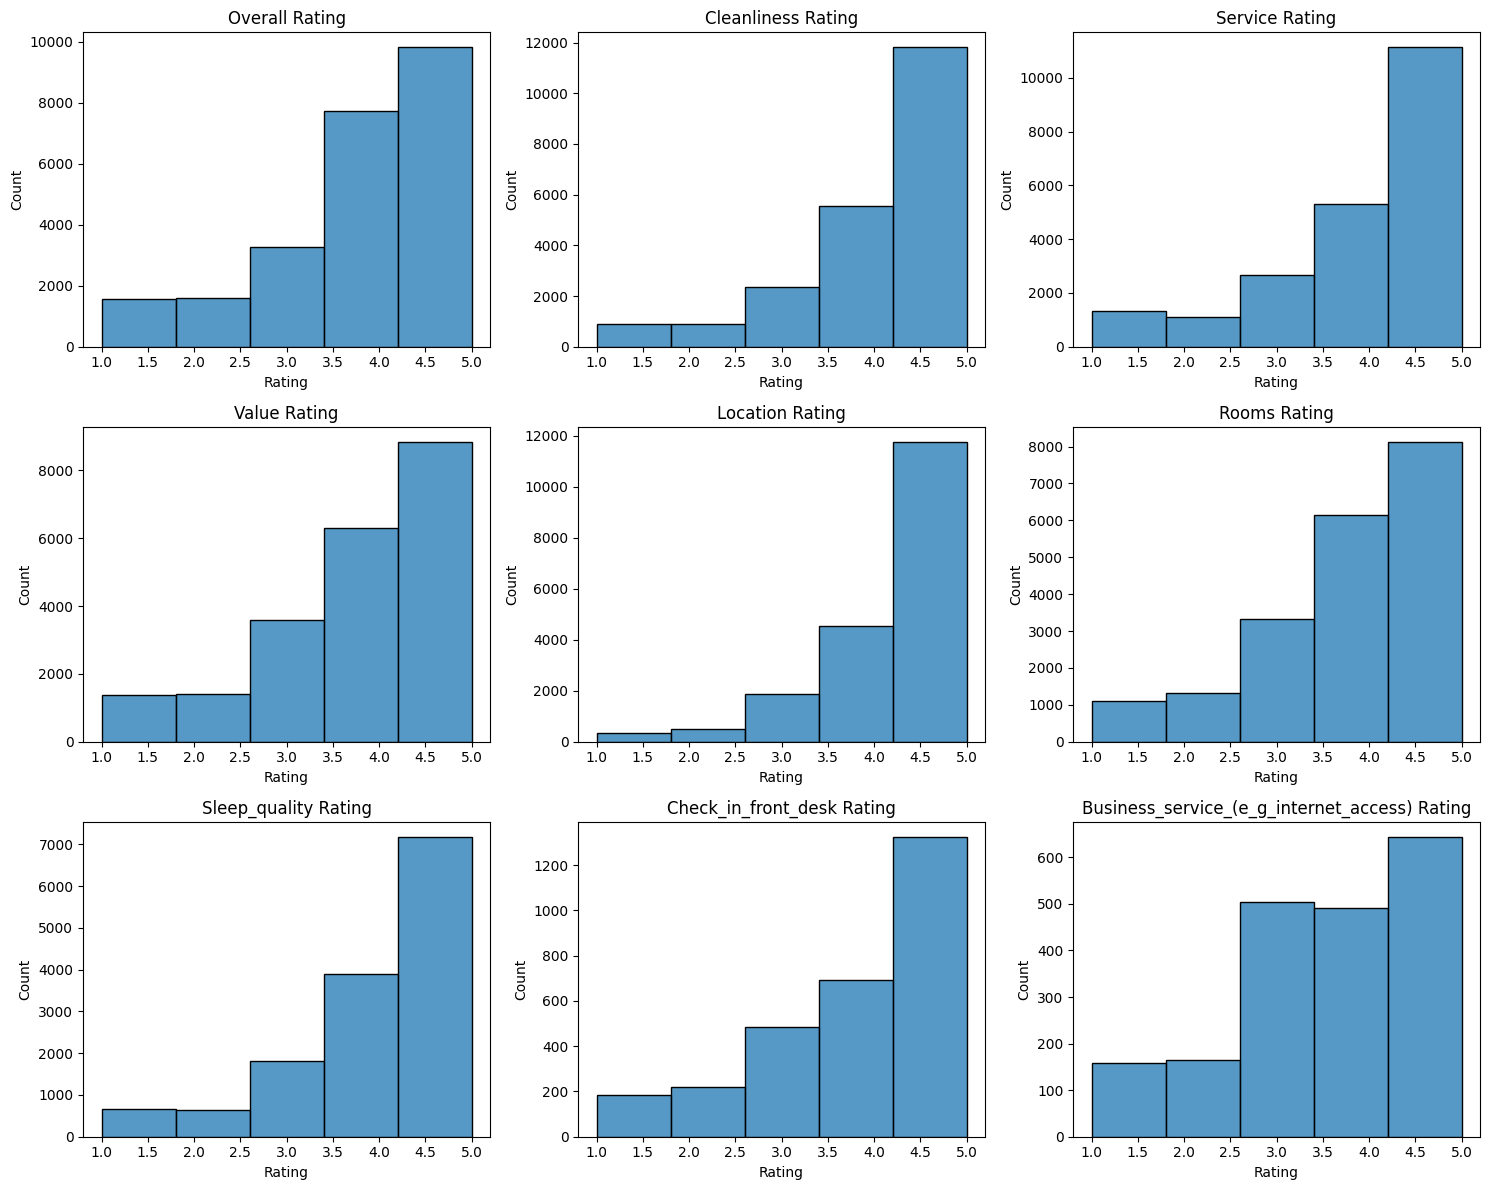

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define rating-related fields
rating_fields = ['overall', 'cleanliness', 'service', 'value', 'location', 'rooms',
                 'sleep_quality', 'check_in_front_desk', 'business_service_(e_g_internet_access)']

# Create a 3x3 subplot grid
fig, axes = plt.subplots(3, 3, figsize=(15, 12)) 

# Loop through rating fields and subplot axes
for ax, field in zip(axes.flatten(), rating_fields):
    if field in train_df.columns:
        sns.histplot(train_df[field].dropna(), bins=5, kde=False, ax=ax)
        ax.set_title(f'{field.capitalize()} Rating')
        ax.set_xlabel('Rating')
        ax.set_ylabel('Count')
    else:
        ax.set_visible(False)  

plt.tight_layout() 
plt.show()

The distribution of overall and aspect-level ratings (e.g., service, cleanliness, value) in the training set reveals the following insights:
1.	Most rating fields exhibit a pronounced right-skewed distribution, with scores concentrated in the $4.0$–$5.0$ range. A rating of $5.0$ is the most common. Certain fields, such as check_in_front_desk and business_service_(e_g_internet_access), have significantly fewer available samples. Meanwhile, attributes like location, sleep_quality, and rooms also show a strong tendency toward high scores, indicating that users generally provided positive feedback on their hotel experiences.

2.	Frequently available rating fields (e.g., overall, cleanliness, service) are more representative and should be prioritized when constructing input prompts for generation models. In contrast, fields with many missing values (e.g., business_service) should be included conditionally during prompt construction to avoid injecting noise or sparsity into the model input.

训练集中的整体评分与各方面评分（如 service、cleanliness、value 等）分布呈现以下特征：
1.	大多数评分维度表现出明显的右偏分布，分数主要集中在 4.0–5.0 区间，其中 5.0 是最常见的评分。部分评分字段（如 check_in_front_desk 和 business_service_(e_g_internet_access)）的样本数量明显偏少；而像 location、sleep_quality 和 rooms 等维度也同样偏向高分，表明用户整体对酒店体验评价较为积极。
2.	高频评分字段（如 overall、cleanliness、service）更具代表性，适合优先纳入生成模型的输入提示中；而缺失较多的字段（如 business_service）在构造 prompt 时应动态判断其是否包含有效信息，以避免引入不必要的噪声。

Token indices sequence length is longer than the specified maximum sequence length for this model (574 > 512). Running this sequence through the model will result in indexing errors


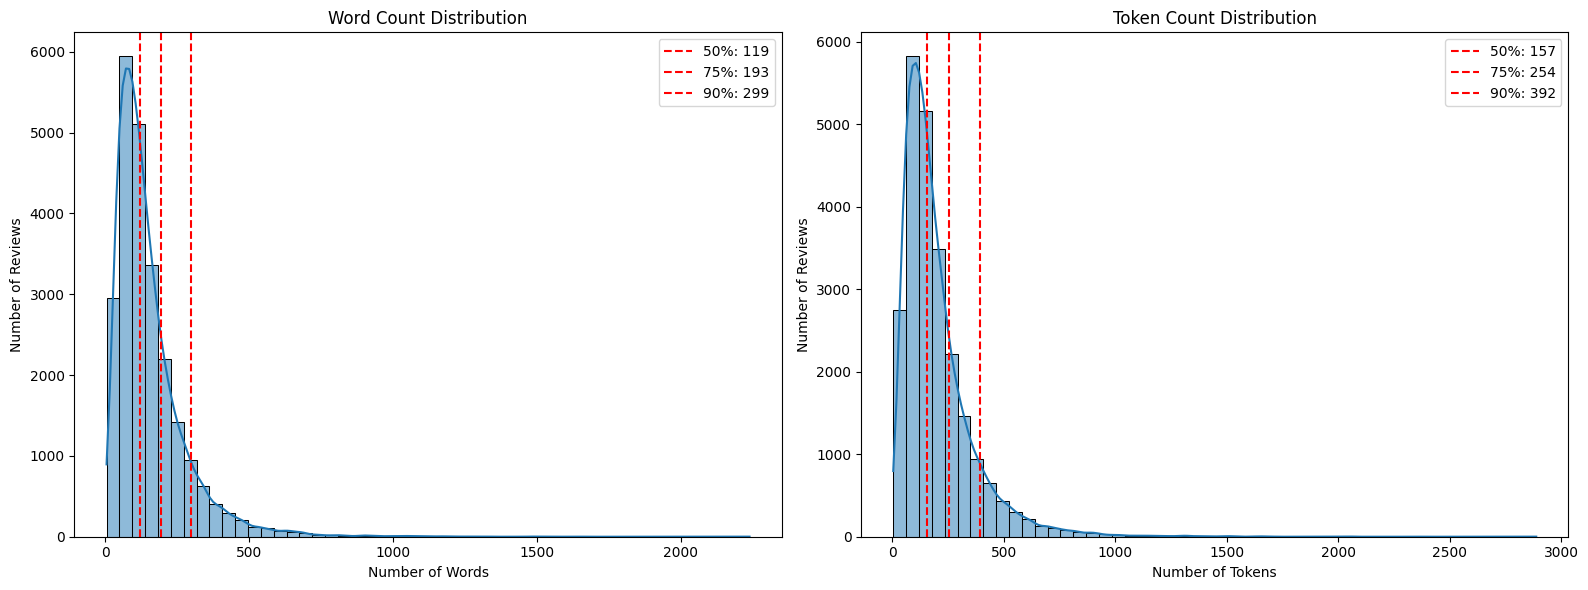

In [7]:
# Calculate number of words per review
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()) if isinstance(x, str) else 0)

# Load T5 tokenizer
tokenizer = T5TokenizerFast.from_pretrained("t5-small")

# Compute token count
train_df['token_count'] = train_df['text'].apply(
    lambda x: len(tokenizer.encode(str(x), truncation=False)) if isinstance(x, str) and x.strip() else 0
)

# Create 1x2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Word count histogram with percentiles
sns.histplot(train_df['word_count'], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Word Count Distribution")
axes[0].set_xlabel("Number of Words")
axes[0].set_ylabel("Number of Reviews")
for p in [0.5, 0.75, 0.9]:
    val = train_df['word_count'].quantile(p)
    axes[0].axvline(val, color='red', linestyle='--', label=f'{int(p*100)}%: {int(val)}')
axes[0].legend()

# Token count histogram with percentiles
sns.histplot(train_df['token_count'], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Token Count Distribution")
axes[1].set_xlabel("Number of Tokens")
axes[1].set_ylabel("Number of Reviews")
for p in [0.5, 0.75, 0.9]:
    val = train_df['token_count'].quantile(p)
    axes[1].axvline(val, color='red', linestyle='--', label=f'{int(p*100)}%: {int(val)}')
axes[1].legend()

plt.tight_layout()
plt.show()

Word and Token Count Distributions:

1.	Word Count Distribution: The median number of words per review is $117$, with $75%$ of reviews containing fewer than $189$ words and 90% fewer than $292$ words. The distribution is heavily right-skewed, indicating that most reviews are relatively short, with only a few exceeding $500$ words.

2.	Token Count Distribution: After tokenization using the T5 tokenizer, the median token count is $163$, with $75%$ of reviews under $262$ tokens and $90%$ under $402$ tokens. Overly long reviews can be safely truncated, while short ones may be padded to ensure consistency in batch processing.

3.	Fairness in Generation Length Settings: To ensure fair comparison between T5-small and GPT-2 in the generation task, both models are constrained to generate at most $128$ tokens. Specifically, T5-small uses max_length=$128$, while GPT-2 uses max_new_tokens=$128$, allowing both to produce comparable-length outputs. Given that 90% of the reviews are shorter than $402$ tokens, this limit captures most meaningful content. Additionally, GPT-2’s max_length during training is capped at $512$ to control the combined length of prompt and target, preventing memory overflow.

评论词数与 Token 数分布:
1.	词数分布：评论的中位词数为 117，75% 的评论少于 189 词，90% 少于 292 词。整体呈现明显的右偏分布，绝大多数评论相对简短，仅有极少数超过 500 词。
2.	Token 数分布：使用 T5 分词器编码后，评论的中位 token 数为 163，75% 的评论少于 262 个 token，90% 少于 402 个 token。过长评论可以适当截断，过短评论则可通过 padding 保证输入的一致性与批处理效率。
3.	生成长度设置的公平性考量：为了确保 T5-small 与 GPT-2 在文本生成任务中的评估具有可比性，我对两者的生成长度进行了统一限制：T5-small 设置 max_length=128，GPT-2 设置 max_new_tokens=128，确保它们最多生成 128 个 token 的文本。由于训练集中 90% 的评论长度低于 402 个 token，这一设置足以涵盖大部分有效内容。在训练阶段，为防止 GPT-2 因输入过长而导致内存溢出，其 max_length 被设置为 512，用于控制 prompt 与生成目标的总输入长度。

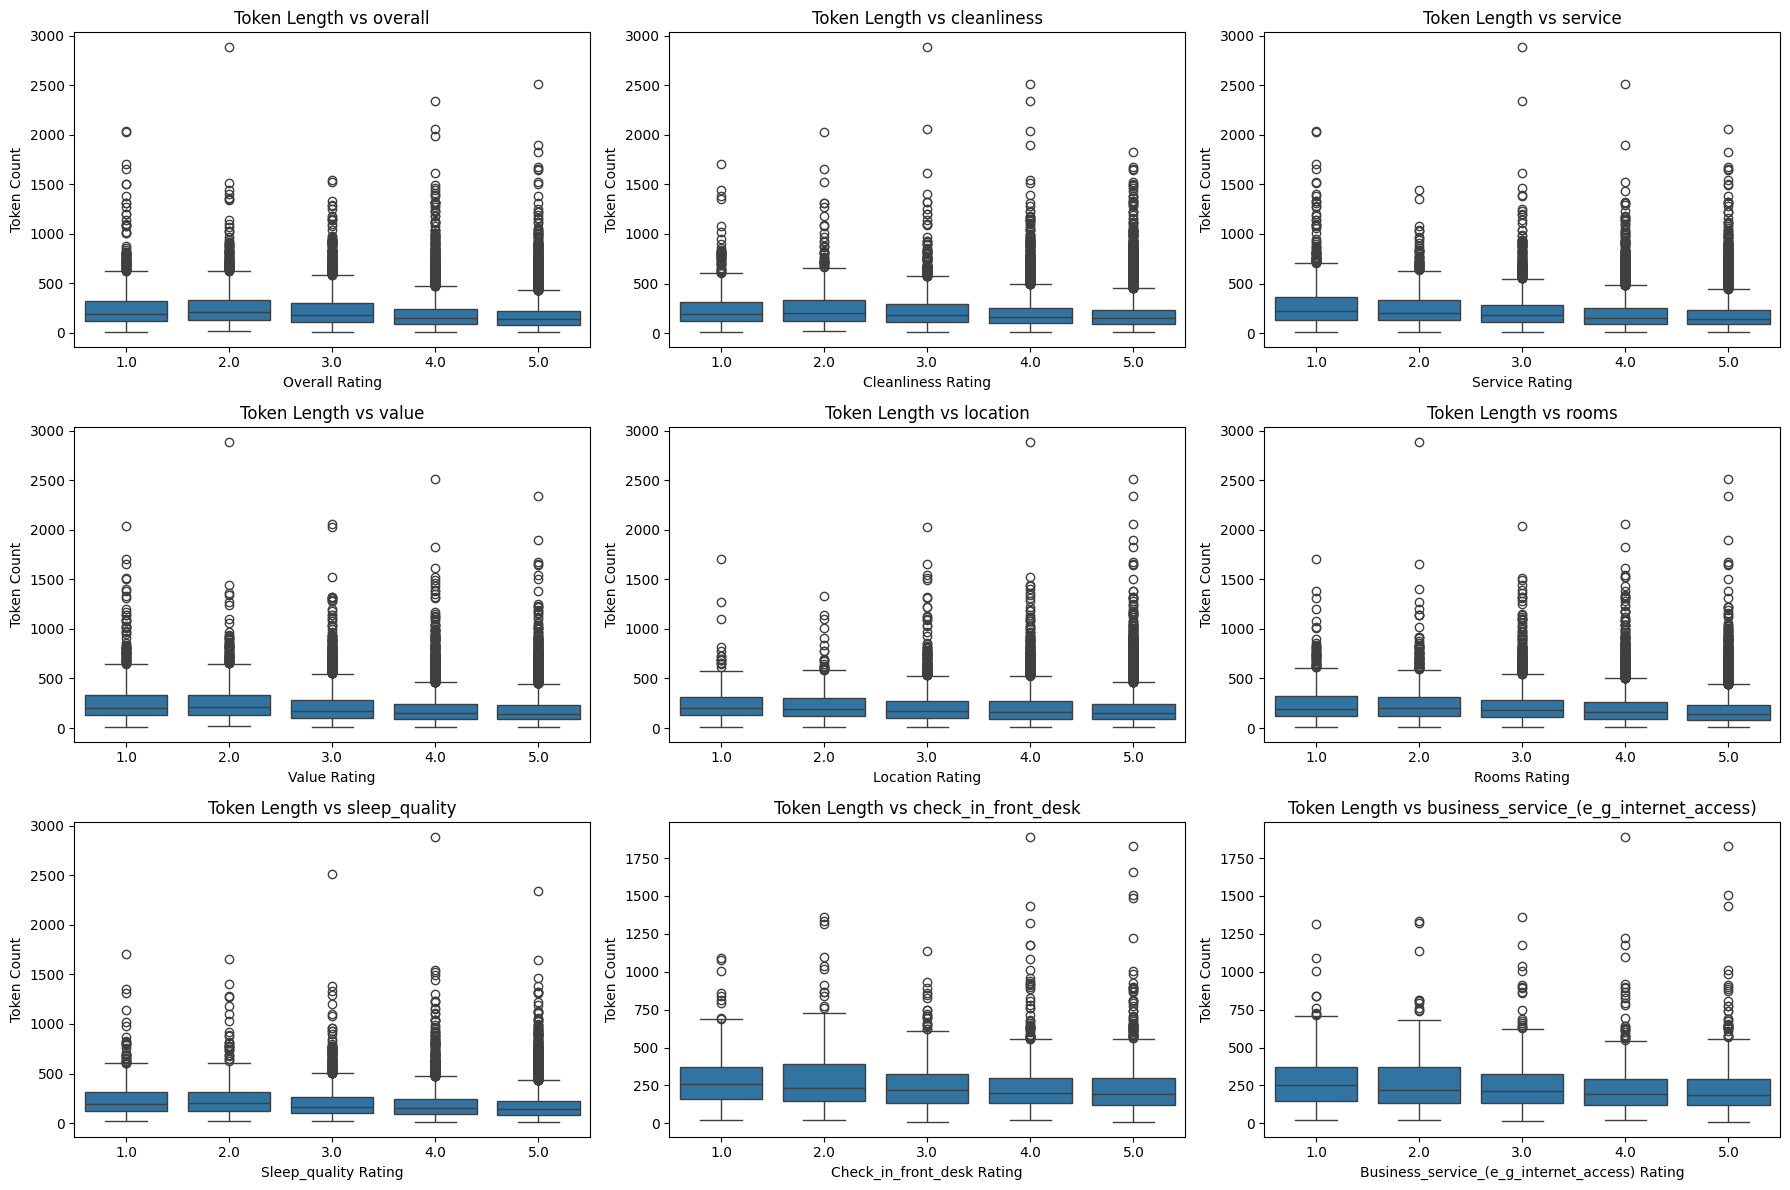

In [8]:
# Show token length per rating score via boxplot
# Create 3x3 subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 12))  

# Loop through each rating field
for ax, field in zip(axes.flatten(), rating_fields):
    if field in train_df.columns:
        sns.boxplot(x=field, y='token_count', data=train_df, ax=ax)
        ax.set_title(f'Token Length vs {field}')
        ax.set_xlabel(f'{field.capitalize()} Rating')
        ax.set_ylabel('Token Count')
    else:
        ax.set_visible(False) 

plt.tight_layout()
plt.show()

Relationship Between Ratings and Review Token Length:

1.	Overall consistency: Token length distributions remain relatively stable across ratings from $1$ to $5$. The interquartile ranges (IQR) are similar, and the medians show minimal variation, suggesting that review length is not strongly influenced by sentiment intensity.

2.	Presence of long-tail reviews: Outliers with significantly longer token counts exist at all rating levels, especially among 4- and 5-star reviews, indicating that highly satisfied users are more likely to write detailed comments.

3.	Slight increase in higher ratings: For certain aspects such as cleanliness, location, and rooms, reviews with a 5-star rating tend to be slightly longer, possibly reflecting the user’s motivation to elaborate on their positive experience.

4.	Rationale for fixed-length generation: While there is some variation in review length across rating levels, we enforce a fixed-length strategy by setting max_length=128 for T5-small and max_new_tokens=128 for GPT-2. This decision ensures consistency across models and evaluation scenarios, minimizing length-induced bias and supporting a fair comparison of generation quality.

评分与评论长度（Token 数）的关系分析

本组箱型图展示了不同评分等级下，评论文本的 token 长度分布情况。主要观察结论如下：
1.	整体趋势稳定：在评分等级为 1 至 5 的区间内，评论长度的分布较为集中，各评分的上下四分位数（IQR）范围接近，中位数差异也较小，表明评分高低对评论长度影响不显著。

2.	存在长尾评论：所有评分等级下均存在一定数量的极长评论（离群值），其中评分为 4 或 5 的评论中长文本更为常见，说明满意的用户有时倾向于写出更详细的评价。

3.	高评分略偏长：在部分维度（如 cleanliness、location、rooms）中，评分为 5 的评论 token 数略高于其他评分，可能反映出用户在给出高分时更愿意表达具体感受与正向情绪。

4.	统一长度策略的必要性：虽然评分与评论长度之间存在一定的相关性，但为了保证文本生成任务中模型训练与评估的一致性与公平性，本项目统一设置 T5-small 的 max_length 和 GPT-2 的 max_new_tokens 为固定长度。这一策略确保了在不同模型、样本和评分条件下的输出长度一致，有效避免因长度变化引发的比较偏差。

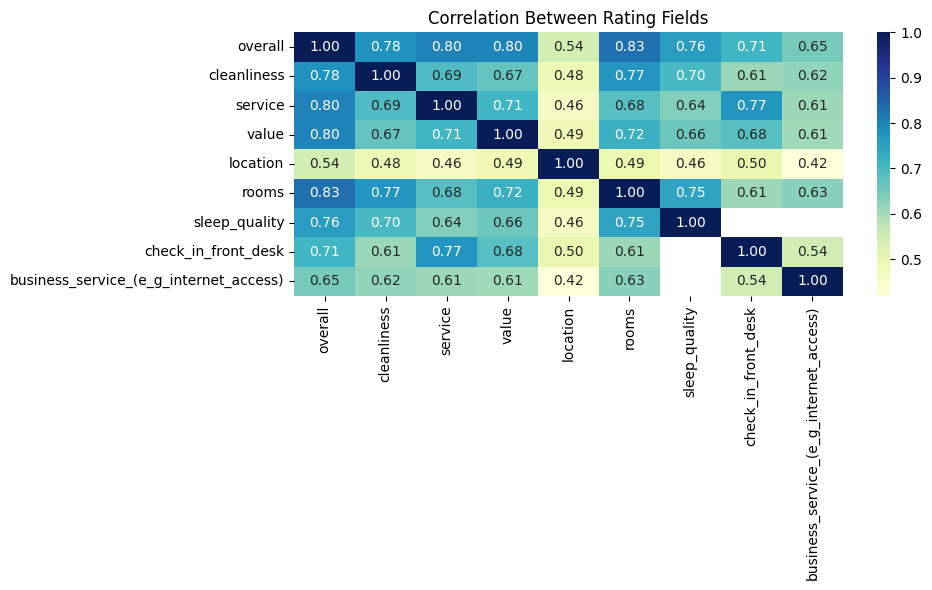

In [9]:
# Compute correlation between rating fields
plt.figure(figsize=(10, 6))
sns.heatmap(train_df[rating_fields].corr(), annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("Correlation Between Rating Fields")
plt.tight_layout()
plt.show()

Correlation Analysis Between Rating Fields:

1.	Generally strong correlations: Most rating fields exhibit correlation coefficients above $0.6$, indicating a consistent rating pattern—users who rate one aspect highly often give high scores to other aspects as well.

2.	Fields strongly correlated with overall: The aspects most strongly correlated with overall are rooms ($0.83$), service ($0.80$), value ($0.80$), and cleanliness ($0.78$). This suggests that these factors contribute more heavily to a user’s overall impression. In contrast, location has a relatively low correlation ($0.54$), indicating it may be evaluated more independently or weigh less in overall satisfaction.

3.	Implications for prompt design and input selection: This correlation analysis offers practical guidance for constructing model input prompts. When not all rating fields can be included due to input length constraints, fields with stronger correlations to overall (e.g., rooms, service, value) should be prioritized to preserve the most influential information. Highly correlated fields may be merged or dimensionally reduced to minimize redundancy. Less correlated fields like location can be optionally excluded if they offer limited value to text generation quality, thereby improving model efficiency and input compactness.

评分维度之间的相关性分析：
1.	整体相关性较高：大多数评分字段之间的相关系数在 0.6 以上，表明用户在评价不同方面时往往表现出一致性，即当某一维度得分较高时，其他维度通常也会获得较高评分。
2.	与 overall 高相关的维度：rooms（0.83）、service（0.80）、value（0.80）以及 cleanliness（0.78）与 overall 的相关性最高，说明这些因素在用户总体评分中占据更高权重。相比之下，location 的相关性较低（0.54），可能说明用户对地理位置的评价相对独立，或权重较小。
3.	对 prompt 构建和模型输入选择的启示：该相关性分析为 prompt 工程提供了参考依据。在输入字段无法全部保留的情况下，应优先保留与 overall 相关性较高的评分项（如 rooms、service、value），以增强评分信号的表达能力。对于高相关字段之间可进行合并或降维处理，避免冗余输入；而像 location 这类相关性较弱的字段，如对生成质量贡献有限，可在输入长度受限时选择性排除，从而提升生成效率与信息密度。

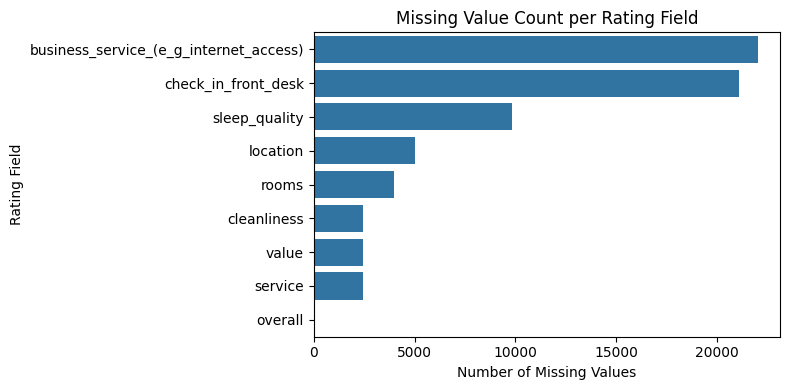

In [10]:
# Count missing values per rating field
missing_counts = train_df[rating_fields].isnull().sum().sort_values(ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(x=missing_counts.values, y=missing_counts.index)
plt.title("Missing Value Count per Rating Field")
plt.xlabel("Number of Missing Values")
plt.ylabel("Rating Field")
plt.tight_layout()
plt.show()

Missing Value Analysis of Rating Fields:
	
1.	Highly sparse fields: business_service_(e_g_internet_access) and check_in_front_desk show the highest number of missing values—over $22,000$ and $21,000$ respectively—indicating that user ratings for these aspects are extremely rare in the dataset.
	
2.	Moderately missing fields: Fields such as sleep_quality (~$10,000$ missing) and location (~$5,000$ missing) also contain a notable amount of missing data, but they are significantly more complete than the two fields above and may still hold value for modeling.

3.	Relatively complete fields: Fields like overall, service, value, cleanliness, and rooms have fewer than $3,000$ missing entries and are largely complete. These can serve as the core components in prompt construction, providing reliable input features for the generation task.

4.	Implications for prompt construction: When building prompts for the model, it is advisable to dynamically include only the available rating fields while skipping the missing ones. This maximizes the use of each sample’s valid information and prevents discarding data unnecessarily. Highly sparse fields (e.g., business_service, check_in_front_desk) should be designed as optional segments in the prompt template to avoid occupying space when data is unavailable. Prioritizing complete fields improves training data coverage and supports model stability during learning.

评分字段缺失值统计分析

1.	整体缺失情况：business_service_(e_g_internet_access) 和 check_in_front_desk 两个字段的缺失值最多，分别超过 22,000 和 21,000 条，几乎覆盖了整个训练集的大多数样本，说明用户对这两项服务的评分出现频率极低。
2.	中等缺失字段：如 sleep_quality（约 10,000 条缺失）和 location（约 5,000 条缺失）也存在一定比例的缺失，但相比前两项已有显著改善，具备一定的使用价值。
3.	相对完整字段：overall、service、value、cleanliness 和 rooms 等字段的缺失值较少（均少于 3,000 条），数据完整性较高，可作为 prompt 构造中的主干输入部分，为模型提供稳定的评分信息。
4.	对 prompt 构建的启示：在构建模型输入提示时，应根据样本的实际字段完整性动态处理缺失信息。建议仅包含存在评分的字段，跳过缺失项，避免因空值造成模型误导或样本废弃。对于缺失严重的字段（如 business_service、check_in_front_desk），可在 prompt 模板中设计为可选段落，提升输入的灵活性与有效性。优先保留缺失率低的字段，有助于提升训练数据利用率与模型泛化稳定性。

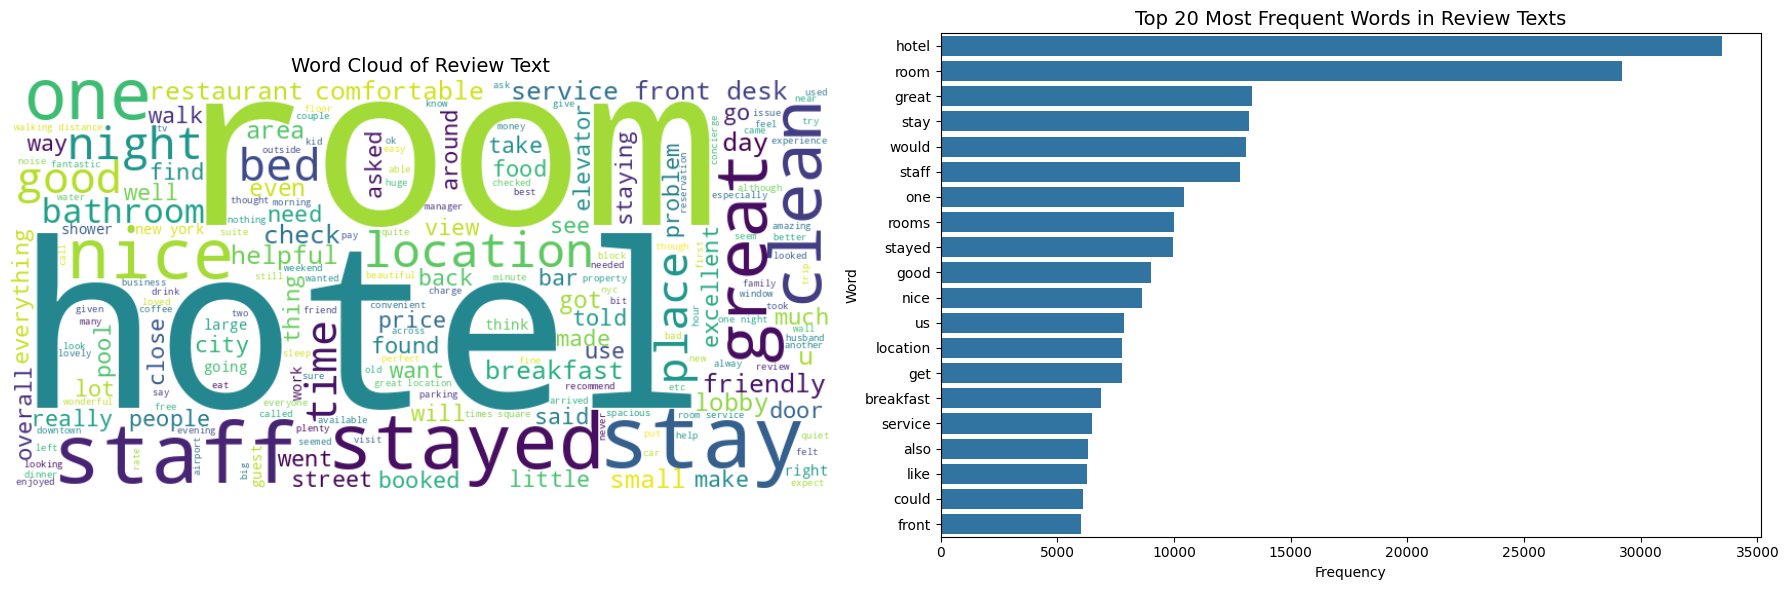

In [11]:
# Download English stopwords from NLTK
#nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Concatenate all reviews into a single string
all_text = " ".join(train_df['text'].dropna().tolist())

# Tokenize and convert to lowercase
word_list = all_text.lower().split()

# Remove stopwords and keep only alphabetic words
filtered_words = [word for word in word_list if word not in stop_words and word.isalpha() and len(word) > 1]

# Count word frequencies
word_freq = Counter(filtered_words)

# Convert the top 20 frequent words to a DataFrame
freq_df = pd.DataFrame(word_freq.most_common(20), columns=['Word', 'Frequency'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Create a 1-row 2-column visualization layout
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot the word cloud
axes[0].imshow(wordcloud, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title("Word Cloud of Review Text", fontsize=14)

# Plot the word frequency bar chart
sns.barplot(x='Frequency', y='Word', data=freq_df, ax=axes[1])
axes[1].set_title('Top 20 Most Frequent Words in Review Texts', fontsize=14)
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('Word')

plt.tight_layout()
plt.show()

Word Cloud and Frequency Statistics:

1.	Distribution of frequent words: As shown in the word cloud and bar chart, the most commonly used words in reviews include hotel, room, stay, staff, great, one, nice, clean, and location. These keywords represent the main aspects users care about—overall experience, room quality, service, and location.

2.	Dominance of positive sentiment: Words such as great, nice, good, and friendly appear frequently. Combined with the earlier observation of a right-skewed rating distribution, this confirms that the dataset is generally positive in tone.

3.	Presence of both content and structural words: Words like staff and room are content nouns, while stay, would, and get serve grammatical or structural roles. This indicates that the review style is conversational, subjective, and expressive.

4.	Implications for prompt design: These high-frequency words highlight common linguistic patterns in user reviews and can inspire more natural and contextually relevant prompt templates to guide text generation.

词云与高频词统计:

1.	高频词汇分布：从词云与柱状图中可以看出，用户评论中最常出现的词汇包括 hotel、room、stay、staff、great、one、nice、clean 和 location 等。这些词高度概括了用户关注的核心方面，如酒店整体体验、房间状况、服务质量与地理位置等。

2.	正面情绪主导：如 great、nice、good、friendly 等正面情绪词汇频繁出现，结合前文评分分布的右偏态趋势，进一步验证了数据集中评论整体偏积极。

3.	实体词与结构词共存：如 staff、room 等为实体名词，stay、would、get 等为结构或动词类词汇。这表明评论文本语言风格较为口语化，强调主观体验和叙述性表达。

4.	对 prompt 设计的启示：这些高频词体现了用户语言中的典型表达方式，可在构建模型输入 prompt 时加以借鉴，以提升生成文本的贴合度与自然性。

# 3. Selection and training Machine Learning models

## 3.1 Model-Oriented Data Preprocessing

In this experiment, I selected two pre-trained language models: T5-small and GPT-2, and fine-tuned them on the dataset for this task. Since each model uses its own tokenizer, I implemented separate tokenization functions for each model to convert the text samples into the required input format.

- For T5-small, I used an instruction-style prompt and encoded both the input prompt and the target text separately to obtain input IDs, attention masks, and labels. To avoid the effect of padding on loss computation, I set the padding tokens in the labels to $-100$.

- For GPT-2, I concatenated the input prompt and the target text into a single sequence, tokenized it, and used it as both input and label. Padding tokens were also set to $-100$ to exclude them from loss computation.


In [12]:
# Split the original training dataset into train and development datasets
train_set, dev_set = train_test_split(train_df, test_size=0.2, random_state=42, shuffle=True)

#Print the size of each split to verify
print(f"Train set size: {len(train_set)}") 
print(f"Dev set size: {len(dev_set)}")


Train set size: 19200
Dev set size: 4800


In [13]:
#Build a natural-language-style prompt
def build_prompt(row, model_type="t5"):

    def describe_score(field, score):
        # Provide semantic labels for scores, e.g., excellent/average/poor
        if score >= 4:
            return f"{field} was excellent ({score})"
        elif score <= 2:
            return f"{field} was poor ({score})"
        else:
            return f"{field} was average ({score})"

    # Define core and optional rating fields
    core_fields = ["overall", "cleanliness", "service", "value", "rooms"]
    optional_fields = ["location", "sleep_quality"]

    rating_strs = []
    for field in core_fields + optional_fields:
        score = row.get(field)
        if pd.notna(score):
            # Convert scores to natural language expressions and add to the list
            rating_strs.append(describe_score(field.replace('_', ' '), score))


    # Build additional context information such as date, source, etc.
    context_parts = []
    if pd.notna(row.get("date_stayed")):
        context_parts.append(f"date stayed: {row['date_stayed']}")
    if pd.notna(row.get("via_mobile")):
        context_parts.append(f"via mobile: {row['via_mobile']}")
    if pd.notna(row.get("num_helpful_votes")) and row['num_helpful_votes'] > 0:
        context_parts.append(f"marked helpful by {row['num_helpful_votes']} users")
    if isinstance(row.get("author"), dict):
        location = row["author"].get("location", "")
        if pd.notna(location) and location != "":
            context_parts.append(f"guest location: {location}")


    # Format prompt based on model type (T5 or GPT-2)
    if model_type == "t5":
        # T5-style: task-specific instruction prompt
        prompt = ""
        if rating_strs:
            prompt += "The guest gave the following feedback: " + "; ".join(rating_strs) + "."
        if context_parts:
            prompt += " Additional context: " + ", ".join(context_parts) + "."
        prompt += " Based on this information, write a possible text:"

    elif model_type == "gpt2":
        # GPT-2-style: simulate continuation from context
        prompt = ""
        if rating_strs:
            prompt += "A customer gave these ratings: " + "; ".join(rating_strs) + "."
        if context_parts:
            prompt += " Context: " + ", ".join(context_parts) + "."
        prompt += " Here's a possible review they might have written: "

    else:

        raise ValueError("Unsupported model_type. Choose 't5' or 'gpt2'.")

    return prompt

In [14]:
train_set["input_prompt"] = train_set.apply(lambda row: build_prompt(row, model_type="t5"), axis=1)
dev_set["input_prompt"] = dev_set.apply(lambda row: build_prompt(row, model_type="t5"), axis=1)

In [ ]:
from transformers import T5Tokenizer
# 1. T5-small: token

# Load T5 tokenizer
t5_tokenizer = T5Tokenizer.from_pretrained("t5-small")

# Tokenization function
def tokenize_t5(sample):
    input_encoding = t5_tokenizer(
        sample['input_prompt'],
        padding="max_length",        # pad to max length
        truncation=True,             # truncate if too long
        max_length=512,
        return_tensors="pt"          # return PyTorch tensors
    )

    target_encoding = t5_tokenizer(
        sample['text'],
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )
    labels = target_encoding.input_ids.squeeze(0)
    labels[labels == t5_tokenizer.pad_token_id] = -100

    return {
        "input_ids": input_encoding.input_ids.squeeze(),         # remove batch dim
        "attention_mask": input_encoding.attention_mask.squeeze(),
        "labels": labels
    }


#Vinit, Text to Text Transfer Transformer. Available at: https://www.kaggle.com/code/vinitkp/text-to-text-transfer-transformer [Accessed 30 May 2025].
#Hugging Face, transformers.T5Tokenizer — Hugging Face Transformers documentation. Available at: https://huggingface.co/docs/transformers/model_doc/t5#transformers.T5Tokenizer [Accessed 30 May 2025].


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
# Load GPT-2 tokenizer
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token  # Important for padding support

# Tokenization function
def tokenize_gpt2(sample):
    full_input = sample['input_prompt'] + " " + sample['text']

    encoding = gpt2_tokenizer(
        full_input,
        padding="max_length",         
        truncation=True,             
        max_length=512,  # (prompt + text)
        return_tensors="pt"
    )

    input_ids = encoding.input_ids.squeeze()
    attention_mask = encoding.attention_mask.squeeze()
    
    labels = input_ids.clone()
    labels[input_ids == gpt2_tokenizer.pad_token_id] = -100

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": input_ids
    }


#Hugging Face, transformers.GPT2Tokenizer — Hugging Face Transformers documentation. Available at: https://huggingface.co/docs/transformers/model_doc/gpt2#transformers.GPT2Tokenizer [Accessed 30 May 2025].



## 3.2 Define evaluation metric functions

This task requires evaluating the semantic similarity between the generated text and the ground truth, from both word-level and sentence-level perspectives. To address this, I designed and implemented four evaluation metrics to assess model performance from different angles:
1.	ROUGE: Structural Overlap Evaluation

    ROUGE (Recall-Oriented Understudy for Gisting Evaluation) is a traditional metric for text generation. It measures n-gram overlap between generated and reference texts, capturing their structural similarity on a surface level.
2.	Greedy Matching: Word-Level Semantic Similarity (via Word Embeddings)

    This metric embeds each word into a semantic space using GloVe word vectors and compares them using cosine similarity, evaluating how closely the predicted and reference texts align in terms of individual word meanings.
3.	BERTScore: Sentence-Level Semantic Similarity (Context-Aware)

    BERTScore leverages contextualized BERT embeddings to assess sentence-level meaning, capturing the semantic closeness between entire sentences rather than focusing on surface-form matches.

4.	Combined Score: Joint Word- and Sentence-Level Semantic Evaluation

    To incorporate both local (word-level) and global (sentence-level) semantic aspects, I created a weighted combination of Greedy Matching and BERTScore:  $combined\_score = \alpha \cdot \text{greedy\_score} + (1 - \alpha) \cdot \text{bertscore\_f1}$

    I set $\alpha = 0.3$ to place more emphasis on sentence-level semantic understanding, reflecting the importance of context and coherence in text generation.

Using these four evaluation metrics, I assessed the outputs of different models (such as T5-small and GPT-2) across various hyperparameter configurations. The comparison allowed me to comprehensively evaluate model performance in terms of structure, word-level meaning, and contextual semantics, providing solid evidence for final model selection.

本次任务要求我们在生成文本与真实文本（ground truth）之间进行语义层面的比较，同时从词级和句子级两个维度进行评估。为此，我设计并实现了四种评估指标，从不同角度量化模型生成结果的质量：

1.	ROUGE：结构重叠度评估

    ROUGE（Recall-Oriented Understudy for Gisting Evaluation）是文本生成任务中常用的传统指标，侧重于评估生成文本与参考文本之间的 n-gram 重叠程度，反映它们在表层结构上的相似性。

2.	Greedy Matching：词级语义匹配（基于词向量）
该指标通过将每个词映射到语义空间（使用 GloVe 词向量），并利用余弦相似度逐词比较生成文本与参考文本之间的语义相似度，衡量词义层面的匹配程度。

3.	BERTScore：句子级语义相似度（上下文感知）
        BERTScore 借助 BERT 的上下文嵌入表示，从整体句子角度出发，比较生成文本与参考文本在语义空间中的接近程度，能够捕捉更深层的语义关系，而非仅仅依赖词面重合。

4.	Combined Score：综合词级与句子级语义评估
    为了同时兼顾局部（词级）和全局（句级）语义信息，我设计了一个加权组合指标，将 Greedy Matching 和 BERTScore 的结果融合在一起：$combined\_score = \alpha \cdot \text{greedy\_score} + (1 - \alpha) \cdot \text{bertscore\_f1}$


    在本实验中，设置 alpha = 0.3，即更偏向句子级语义理解（BERTScore），以更好地反映文本的整体语义连贯性。

我使用上述四种评估指标，对不同模型（如 T5-small 和 GPT-2）在多组超参数配置下的输出结果进行了评估。通过这些指标的比较，能够从结构相似性、词义匹配和上下文理解等多个层面全面评估模型性能，为最终模型选择提供可靠依据。


In [ ]:
# 1. General Evaluation Metrics-rouge
def compute_rouge_f1(predictions, references):

    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    rouge1_f1 = []
    rouge2_f1 = []
    rougel_f1 = []

    for pred, ref in zip(predictions, references):
        scores = scorer.score(ref, pred)
        rouge1_f1.append(scores['rouge1'].fmeasure)
        rouge2_f1.append(scores['rouge2'].fmeasure)
        rougel_f1.append(scores['rougeL'].fmeasure)

    return {
        "ROUGE-1 F1": sum(rouge1_f1) / len(rouge1_f1),
        "ROUGE-2 F1": sum(rouge2_f1) / len(rouge2_f1),
        "ROUGE-L F1": sum(rougel_f1) / len(rougel_f1)
    }

#Google Research, google-research/rouge. GitHub. Available at: https://github.com/google-research/google-research/tree/master/rouge [Accessed 30 May 2025].
#Lightning AI, ROUGE Score — TorchMetrics documentation. Available at: https://lightning.ai/docs/torchmetrics/stable/text/rouge_score.html [Accessed 30 May 2025].

In [ ]:
# 2. Word-Level Semantic Similarity-Greedy Word Embedding Matching
# Download and load pre-trained GloVe 300-dimensional word vectors
word_vectors = api.load("glove-wiki-gigaword-300")

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def greedy_matching_score(ref_tokens, pred_tokens, word_vectors):
    """
    Compute the Greedy Word Embedding Matching score (word-level semantic similarity) between two token lists.

    Args:
        ref_tokens (List[str]):Tokenized reference text (ground truth)
        pred_tokens (List[str]): Tokenized predicted/generated text
        word_vectors (gensim KeyedVectors):Pre-trained word embedding model 

    Returns:
        float: Greedy matching similarity score (between 0 and 1, higher means more semantically similar)
    """

    def get_vectors(tokens):
        # Get vectors for all tokens that exist in the word embedding model
        return np.array([word_vectors[word] for word in tokens if word in word_vectors])

    vec_ref = get_vectors(ref_tokens)
    vec_pred = get_vectors(pred_tokens)

    # Return 0.0 if no valid embeddings are found in either sentence
    if len(vec_ref) == 0 or len(vec_pred) == 0:
        return 0.0

    # Compute cosine similarity matrix between predicted and reference vectors
    sim_matrix = cosine_similarity(vec_pred, vec_ref)

    # For each predicted word, find the most similar reference word
    max_pred_to_ref = np.mean(np.max(sim_matrix, axis=1))

    # For each reference word, find the most similar predicted word
    max_ref_to_pred = np.mean(np.max(sim_matrix, axis=0))

    # Final score is the average of both directions
    return (max_pred_to_ref + max_ref_to_pred) / 2


#Liu, C.-W., Lowe, R., Serban, I.V., Noseworthy, M., Charlin, L. & Pineau, J., 2016. How NOT to Evaluate Your Dialogue System: An Empirical Study of Unsupervised Evaluation Metrics for Dialogue Response Generation. arXiv preprint arXiv:1603.08023. Available at: https://doi.org/10.48550/arXiv.1603.08023 [Accessed 30 May 2025].

In [ ]:
# 3. Sentence-Level Semantic Similarity-BERTScore
def compute_bertscore(predictions, references, lang="en"):
    """
    Compute average BERTScore precision, recall, and F1.
    """
    P, R, F1 = score(predictions, references, lang=lang)
    return {
        'bertscore_precision': P.mean().item(),
        'bertscore_recall': R.mean().item(),
        'bertscore_f1': F1.mean().item()
    }

#Tiiiger, 2019. BERTScore Demo Notebook. GitHub. Available at: https://github.com/Tiiiger/bert_score/blob/master/example/Demo.ipynb [Accessed 30 May 2025].
#Zhang, T., Kishore, V., Wu, F., Weinberger, K.Q. & Artzi, Y., 2020. BERTScore: Evaluating Text Generation with BERT. arXiv preprint arXiv:1904.09675. Available at: https://doi.org/10.48550/arXiv.1904.09675 [Accessed 30 May 2025].

In [20]:
# 4. Combined Semantic Evaluation
def combined_semantic_score(greedy_score, bert_f1_score, alpha=0.3):
    """
    Combine word-level and sentence-level semantic scores using weighted average.

    Args:
        greedy_score (float): Greedy word embedding matching score
        bert_f1_score (float): BERTScore F1
        alpha (float): Weight for greedy score (0 <= alpha <= 1)

    Returns:
        float: Combined semantic similarity score
    """
    return alpha * greedy_score + (1 - alpha) * bert_f1_score

In [21]:
# 5. Define the evaluate all metrics function 
def evaluate_all_metrics(preds, refs, word_vectors):
    # 1. ROUGE
    rouge = compute_rouge_f1(preds, refs)

    # 2. Greedy Matching (word-level semantic)
    greedy_scores = [
        greedy_matching_score(ref.split(), pred.split(), word_vectors)
        for ref, pred in zip(refs, preds)
    ]
    greedy = sum(greedy_scores) / len(greedy_scores)

    # 3. BERTScore
    bert = compute_bertscore(preds, refs)
    bert_f1 = bert['bertscore_f1']

    # 4. Combined Score
    combined = combined_semantic_score(greedy, bert_f1)

    return {
        **rouge,
        'greedy_score': greedy,
        **bert,
        'combined_score': combined
    }

# 4. Model Fine-Tuning and Hyperparameter Selection (T5 and GPT-2)

## 4.1 T5-Small model

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import T5ForConditionalGeneration, T5Tokenizer, get_scheduler
from torch.optim import AdamW
from tqdm import tqdm
import pandas as pd

# Custom Dataset class for tokenizing each row
class T5FineTuneDataset(Dataset):
    def __init__(self, dataframe, tokenizer_func):
        self.dataframe = dataframe
        self.tokenizer_func = tokenizer_func

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        sample = self.dataframe.iloc[idx]
        return self.tokenizer_func(sample)

# Training + validation for a single hyperparameter config
def run_single_t5_training(train_df, val_df, tokenizer_func, tokenizer, learning_rate=5e-5, batch_size=8, num_epochs=3):
    
    # Set device: use GPU if available, otherwise CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)

    # Load train and validation sets
    train_dataset = T5FineTuneDataset(train_df, tokenizer_func)
    val_dataset = T5FineTuneDataset(val_df, tokenizer_func)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1)

    # Set optimizer and LR scheduler
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    lr_scheduler = get_scheduler(
        "linear", optimizer=optimizer, num_warmup_steps=0,
        num_training_steps=len(train_loader) * num_epochs
    )

    # Containers to store average training and development losses per epoch
    train_losses = []
    dev_losses = []

    # Training loop
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"[Epoch {epoch+1}] Avg Training Loss: {avg_train_loss:.4f}")

        # Evaluation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                total_val_loss += outputs.loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        dev_losses.append(avg_val_loss)
        print(f"[Epoch {epoch+1}] Avg Dev Loss: {avg_val_loss:.4f}")

        import sys
        sys.stdout.flush()
        model.train()

    # Prediction on validation set
    model.eval()
    predictions, references = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            output_ids = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_new_tokens=128)
            try:
                pred = tokenizer.decode(output_ids[0], skip_special_tokens=True)
                label_ids = torch.where(labels[0] == -100, tokenizer.pad_token_id, labels[0])
                ref = tokenizer.decode(label_ids, skip_special_tokens=True)
            except Exception as e:
                print("Decoding error:", e)
                print("Output IDs:", output_ids[0])
                print("Label IDs:", labels[0])
                raise

            predictions.append(pred)
            references.append(ref)

    return predictions, references, train_losses, dev_losses, model


#Hugging Face, 2025. T5 Model Documentation. Available at: https://huggingface.co/docs/transformers/model_doc/t5 [Accessed 30 May 2025].


In [23]:
# Grid search multiple hyperparameter configs
def run_grid_search(train_df, val_df, tokenizer_func, word_vectors,output_csv="all_results.csv"):

    # Hyperparameter options
    learning_rates = [5e-5, 1e-4] 
    batch_sizes = 8                   
    num_epochs = 3                   
    
    results = []     
    loss_logs = []  
    
    # Initialize variables for saving best model
    best_combined = -1.0  
    best_model = None    
    best_tokenizer = None 
    best_config = {}
    
    tokenizer = T5Tokenizer.from_pretrained("t5-small")
    
    # Iterate over each learning rate configuration
    for lr in learning_rates:
        print(f"\nRunning config: learning_rate={lr}")

        # Run training and get predictions, references, and losses
        predictions, references, train_losses, dev_losses,model = run_single_t5_training(
            train_df=train_df,
            val_df=val_df,
            tokenizer_func=tokenizer_func,
            tokenizer=tokenizer,
            learning_rate=lr,
            batch_size=batch_sizes,
            num_epochs=num_epochs
        )

        # Evaluate predictions using external metric function
        metrics = evaluate_all_metrics(predictions, references, word_vectors)


        # Store result for comparison
        result = {
            "learning_rate": lr,
            "batch_size": batch_sizes,
            "num_epochs": num_epochs,
            **metrics  
        }
        results.append(result)

        # Store training and dev loss for plotting later
        loss_logs.append({
            "learning_rate": lr,
            "train_losses": train_losses,
            "dev_losses": dev_losses
        })
        
        # Check if this is the best model so far based on combined_score
        if metrics["combined_score"] > best_combined:
            best_combined = metrics["combined_score"]
            best_config = {
                "learning_rate": lr,
                "batch_size": batch_sizes,
                "num_epochs": num_epochs
            }
            print(f"New best model found with combined_score = {best_combined:.4f}")
            model.save_pretrained("best_model_t5")
            tokenizer.save_pretrained("best_model_t5")


    # Save all evaluation results to a CSV file for review
    df_results = pd.DataFrame(results)
    try:
        df_results.to_csv(output_csv, mode='a', index=False, header=not pd.read_csv(output_csv).empty)
    except FileNotFoundError:
        df_results.to_csv(output_csv, index=False)

    print(f"\nAll results saved to {output_csv}")


    # Print the best model configuration summary
    print("\nBest Model Config:")
    for k, v in best_config.items():
        print(f"{k}: {v}") 


    return df_results, loss_logs

In [24]:
results_t5, loss_logs_t5 = run_grid_search(
    train_df=train_set,
    val_df=dev_set,
    tokenizer_func=tokenize_t5,
    word_vectors=word_vectors,
    output_csv="all_results.csv"
)


Running config: learning_rate=5e-05


Epoch 1: 100%|██████████| 2400/2400 [03:37<00:00, 11.02it/s]


[Epoch 1] Avg Training Loss: 3.7603
[Epoch 1] Avg Dev Loss: 3.4682


Epoch 2: 100%|██████████| 2400/2400 [03:36<00:00, 11.08it/s]


[Epoch 2] Avg Training Loss: 3.6247
[Epoch 2] Avg Dev Loss: 3.4182


Epoch 3: 100%|██████████| 2400/2400 [03:37<00:00, 11.02it/s]


[Epoch 3] Avg Training Loss: 3.5877
[Epoch 3] Avg Dev Loss: 3.4049


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


New best model found with combined_score = 0.7999

Running config: learning_rate=0.0001


Epoch 1: 100%|██████████| 2400/2400 [03:38<00:00, 10.97it/s]


[Epoch 1] Avg Training Loss: 3.6905
[Epoch 1] Avg Dev Loss: 3.4041


Epoch 2: 100%|██████████| 2400/2400 [03:39<00:00, 10.92it/s]


[Epoch 2] Avg Training Loss: 3.5463
[Epoch 2] Avg Dev Loss: 3.3478


Epoch 3: 100%|██████████| 2400/2400 [03:38<00:00, 10.97it/s]


[Epoch 3] Avg Training Loss: 3.5005
[Epoch 3] Avg Dev Loss: 3.3323


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


New best model found with combined_score = 0.8026

All results saved to all_results.csv

Best Model Config:
learning_rate: 0.0001
batch_size: 8
num_epochs: 3


## 4.2 GPT-2 model

In [ ]:
# Custom Dataset class for GPT-2 tokenization
class GPT2FineTuneDataset(Dataset):
    def __init__(self, dataframe, tokenizer_func):
        self.dataframe = dataframe
        self.tokenizer_func = tokenizer_func

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        sample = self.dataframe.iloc[idx]
        return self.tokenizer_func(sample)

# Training + validation function for GPT-2
def run_single_gpt2_training(train_df, val_df, tokenizer_func, tokenizer,
                              learning_rate=5e-5, batch_size=4, num_epochs=3):
    
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load GPT-2 model and resize token embeddings
    model = GPT2LMHeadModel.from_pretrained("gpt2")
    model.resize_token_embeddings(len(tokenizer))
    model = model.to(device)

    # Load train and validation data
    train_dataset = GPT2FineTuneDataset(train_df, tokenizer_func)
    val_dataset = GPT2FineTuneDataset(val_df, tokenizer_func)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1)

    # Optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    lr_scheduler = get_scheduler(
        "linear", optimizer=optimizer, num_warmup_steps=0,
        num_training_steps=len(train_loader) * num_epochs
    )


    # Loss tracking
    train_losses = []
    dev_losses = []

    # Start training
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0

        # Training for each batch
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"[Epoch {epoch+1}] Avg Training Loss: {avg_train_loss:.4f}")

        # Validation phase (using development set) to compute loss
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                total_val_loss += outputs.loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        dev_losses.append(avg_val_loss)
        print(f"[Epoch {epoch+1}] Avg Dev Loss: {avg_val_loss:.4f}")
        
        import sys
        sys.stdout.flush()
        
        model.train()

    # Inference for predictions vs references
    model.eval()
    predictions = []
    references = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            output_ids = model.generate(
                input_ids=input_ids, 
                attention_mask=attention_mask, 
                max_new_tokens=128,
                pad_token_id=gpt2_tokenizer.pad_token_id)
            pred = tokenizer.decode(output_ids[0], skip_special_tokens=True)
            ref = tokenizer.decode(input_ids[0], skip_special_tokens=True)

            predictions.append(pred)
            references.append(ref)


    # Return predictions, references, training loss, and dev loss
    return predictions, references, train_losses, dev_losses, model

#Bhattiprolu, S., 2023. Fine-tuning GPT-2 for Text Generation. Google Colab. Available at: https://colab.research.google.com/github/bnsreenu/python_for_microscopists/blob/master/311_fine_tuning_GPT2.ipynb [Accessed 30 May 2025].

In [26]:
# Grid search multiple hyperparameter configs for GPT-2
def run_grid_search_gpt2(train_df, val_df, tokenizer_func, tokenizer, word_vectors,output_csv="all_results.csv"):

    # Define hyperparameter ranges
    learning_rates = [5e-5, 1e-4]
    batch_sizes = 8
    num_epochs = 3

    results = []      
    loss_logs = []    

    # Initialize variables for saving best model
    best_combined = -1.0
    best_model = None
    best_tokenizer = None
    best_config = {}

    for lr in learning_rates:
        print(f"\n Running config: learning_rate={lr}")

        # Run training and get predictions, references, and loss history
        predictions, references, train_losses, dev_losses,model = run_single_gpt2_training(
            train_df=train_df,
            val_df=val_df,
            tokenizer_func=tokenizer_func,
            tokenizer=tokenizer,
            learning_rate=lr,
            batch_size=batch_sizes,
            num_epochs=num_epochs
        )

        # Evaluate predictions using external metric function
        metrics = evaluate_all_metrics(predictions, references, word_vectors)


        # Store current configuration result
        result = {
            "learning_rate": lr,
            "batch_size": batch_sizes,
            "num_epochs": num_epochs,
            **metrics
        }
        results.append(result)

        # Store loss logs for visualization
        loss_logs.append({
            "learning_rate": lr,
            "train_losses": train_losses,
            "dev_losses": dev_losses
        })
        # If this is the best model, save it
        if metrics["combined_score"] > best_combined:
            print(f"New best model found with combined_score = {metrics['combined_score']:.4f}")
            best_combined = metrics["combined_score"]

            # Save clean tokenizer & model
            model.save_pretrained("best_model_gpt2") 
            tokenizer.save_pretrained("best_model_gpt2")

            best_config = {
                "learning_rate": lr,
                "batch_size": batch_sizes,
                "num_epochs": num_epochs
            }

    # CSV Save all results to CSV
    df_results = pd.DataFrame(results)
    try:
        df_results.to_csv(output_csv, mode='a', index=False, header=not pd.read_csv(output_csv).empty)
    except FileNotFoundError:
        df_results.to_csv(output_csv, index=False)
        
    print(f"\nAll results saved to {output_csv}")

    # Print best configuration
    print("\nBest Model Config:")
    for k, v in best_config.items():
        print(f"{k}: {v}")


    # Return metrics and loss logs
    return df_results, loss_logs

In [27]:
results_gpt2, loss_logs_gpt2 = run_grid_search_gpt2(
    train_df=train_set,
    val_df=dev_set,
    tokenizer_func=tokenize_gpt2,
    tokenizer=gpt2_tokenizer,
    word_vectors=word_vectors,
    output_csv="all_results.csv"
    
)


 Running config: learning_rate=5e-05


Epoch 1: 100%|██████████| 2400/2400 [05:18<00:00,  7.54it/s]


[Epoch 1] Avg Training Loss: 1.2072
[Epoch 1] Avg Dev Loss: 1.1285


Epoch 2: 100%|██████████| 2400/2400 [05:17<00:00,  7.55it/s]


[Epoch 2] Avg Training Loss: 1.1195
[Epoch 2] Avg Dev Loss: 1.1080


Epoch 3: 100%|██████████| 2400/2400 [05:18<00:00,  7.54it/s]


[Epoch 3] Avg Training Loss: 1.0899
[Epoch 3] Avg Dev Loss: 1.1011


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


New best model found with combined_score = 0.9999

 Running config: learning_rate=0.0001


Epoch 1: 100%|██████████| 2400/2400 [05:16<00:00,  7.59it/s]


[Epoch 1] Avg Training Loss: 1.1854
[Epoch 1] Avg Dev Loss: 1.1139


Epoch 2: 100%|██████████| 2400/2400 [05:17<00:00,  7.56it/s]


[Epoch 2] Avg Training Loss: 1.0900
[Epoch 2] Avg Dev Loss: 1.0918


Epoch 3: 100%|██████████| 2400/2400 [05:17<00:00,  7.56it/s]


[Epoch 3] Avg Training Loss: 1.0485
[Epoch 3] Avg Dev Loss: 1.0851


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



All results saved to all_results.csv

Best Model Config:
learning_rate: 5e-05
batch_size: 8
num_epochs: 3


## 4.3 Validation-Based Evaluation and Model Selection

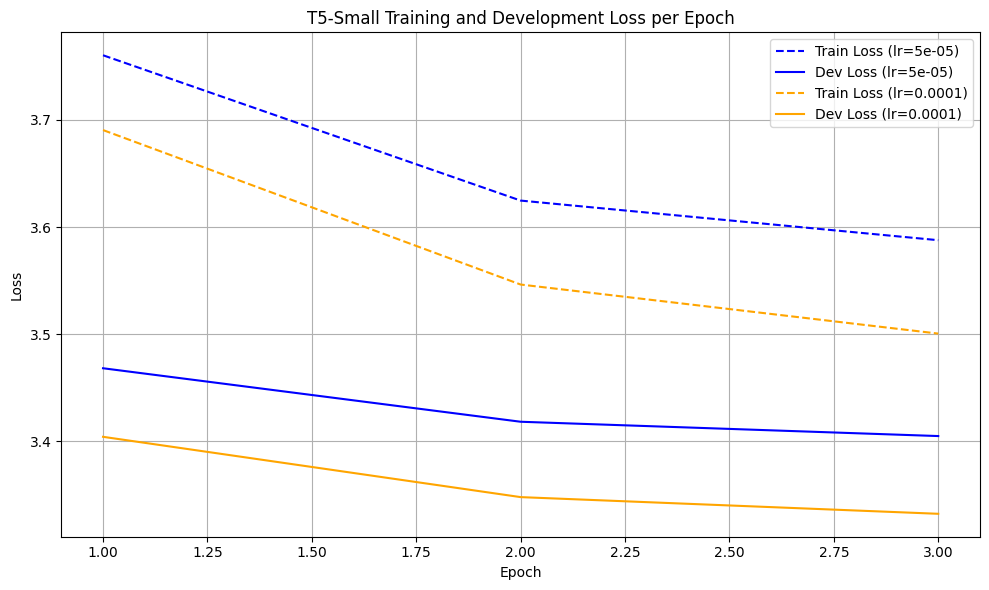

In [28]:
# T5-small training & dev loss visualization
def plot_loss_curves(loss_logs):
    # Create a figure with specified size
    plt.figure(figsize=(10, 6))
    
    # Set up colors
    colors = ['blue', 'orange']
    lr_to_color = {}  
    color_idx = 0
    
    # Iterate over each hyperparameter config's loss logs
    for log in loss_logs:
        lr = log['learning_rate']  
        train_losses = log['train_losses'] 
        dev_losses = log['dev_losses']     
        epochs = list(range(1, len(train_losses) + 1))  
        
        #Assign colors
        if lr not in lr_to_color:
            lr_to_color[lr] = colors[color_idx]
            color_idx += 1

        color = lr_to_color[lr]
        
        # Plot training loss curve (dashed line)
        plt.plot(epochs, train_losses, label=f"Train Loss (lr={lr})", linestyle='--', color=color)
        # Plot dev loss curve (solid line)
        plt.plot(epochs, dev_losses, label=f"Dev Loss (lr={lr})", linestyle='-', color=color)

    # Set labels and title
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("T5-Small Training and Development Loss per Epoch")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("loss_curves_t5.png")
    plt.show()

# Call the plotting function
plot_loss_curves(loss_logs_t5)

T5-small Model Experimental Analysis:

- In this experiment, I fine-tuned the pre-trained T5-small model and compared its performance under two different learning rates on both the training and development sets. The results showed that for both learning rates, the training and validation losses consistently decreased over epochs, indicating a stable training process and effective model convergence.

- Compared to the learning rate of 5e-5, the model trained with a higher learning rate of 1e-4 achieved lower loss values on both the training and development sets, suggesting faster convergence and better overall performance. The loss curves were smooth and stable, with no signs of oscillation or overfitting, demonstrating that the hyperparameter settings were appropriate.

- Among all configurations tested, the model with a learning rate of 1e-4 achieved the best performance in terms of the combined semantic score, reaching a value of $0.8026$

T5-small 模型实验分析

在本次实验中，我对预训练的 T5-small 模型进行了微调，并比较了两种不同学习率在训练集和开发集上的表现。实验结果显示，在两种学习率设置下，训练损失和验证损失均随着训练轮数的增加而持续下降，表明模型训练过程稳定，且具备良好的收敛性。

与学习率 5e-5 相比，使用较高学习率 1e-4 训练的模型在训练集和开发集上都获得了更低的损失值，说明该设置下模型收敛速度更快，整体性能更优。损失曲线平滑稳定，无明显震荡或过拟合现象，进一步证明超参数设置合理。

在所有测试配置中，学习率为 1e-4 的模型在综合语义评分（combined semantic score）方面表现最佳，得分达到 0.8026。

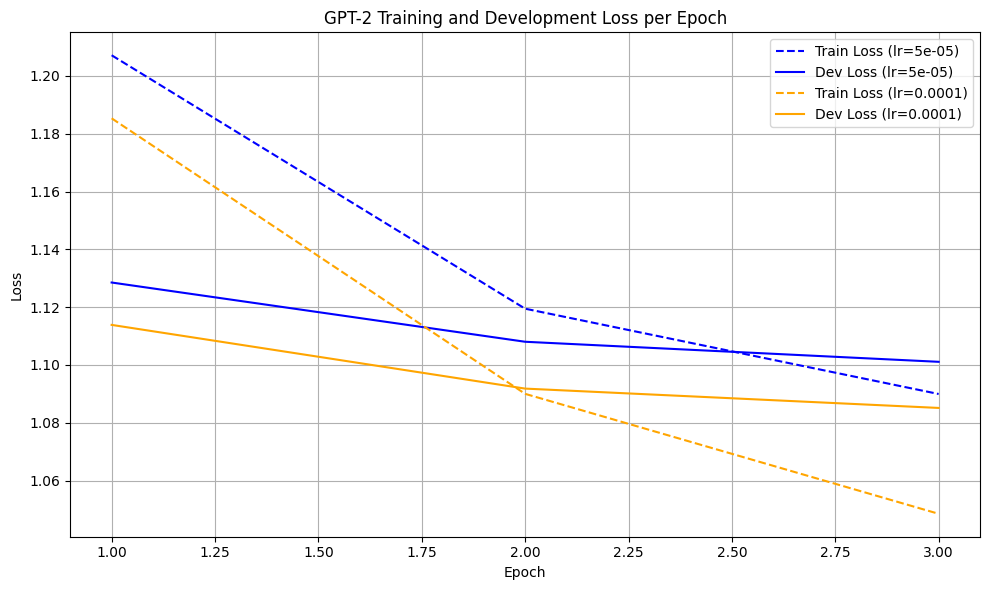

In [29]:
# GPT-2 training & dev loss visualization
def plot_loss_curves_gpt2(loss_logs):

    plt.figure(figsize=(10, 6))
    
    # Set up colors
    colors = ['blue', 'orange']
    lr_to_color = {}  
    color_idx = 0

    # Iterate over each hyperparameter config's loss logs
    for log in loss_logs:
        lr = log['learning_rate']  
        train_losses = log['train_losses'] 
        dev_losses = log['dev_losses']      
        epochs = list(range(1, len(train_losses) + 1)) 
        
        #Assign colors
        if lr not in lr_to_color:
            lr_to_color[lr] = colors[color_idx]
            color_idx += 1

        color = lr_to_color[lr]

        # Plot training loss curve (dashed line)
        plt.plot(epochs, train_losses, label=f"Train Loss (lr={lr})", linestyle='--', color=color)
        
        # Plot dev loss curve (solid line)
        plt.plot(epochs, dev_losses, label=f"Dev Loss (lr={lr})", linestyle='-', color=color)

    # Set labels and title
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("GPT-2 Training and Development Loss per Epoch")
    plt.legend()
    plt.grid(True)


    plt.tight_layout()
    plt.savefig("loss_curves_gpt2.png")
    plt.show()


# Call the plotting function
plot_loss_curves_gpt2(loss_logs_gpt2)

GPT-2 Model Experimental Analysis:

- In this experiment, I fine-tuned the pre-trained GPT-2 model and evaluated its performance under two different learning rates (5e-5 and 1e-4) on both the training and development sets. To ensure a fair comparison with the T5-small model, all hyperparameters were kept consistent with the T5-small setup.

- Overall, the training process was stable, with losses gradually decreasing over time. As shown in the plot, both training losses (dashed lines) and development losses (solid lines) steadily decreased across epochs for both learning rates, indicating effective convergence and model learning.

- Compared to the 1e-4 configuration, the model trained with a learning rate of 5e-5 exhibited slower but more stable reduction in validation loss and ultimately achieved a lower dev loss by the final epoch. All curves were smooth and stable without any sharp fluctuations, suggesting a well-configured training process with no signs of overfitting.

- Although the 1e-4 model achieved lower training loss, the model trained with 5e-5 achieved the best performance in terms of the combined semantic score, reaching an impressive $0.9999$.

GPT-2 模型实验分析

在本次实验中，我对预训练的 GPT-2 模型进行了微调，并在训练集与开发集上比较了两种不同学习率（5e-5 和 1e-4）下的模型性能。为了便于与 T5-small 模型进行公平对比，本实验中的超参数设置与 T5-small 的实验保持一致。

从整体趋势来看，训练过程较为稳定，损失值呈现出持续下降的趋势。从图中可以观察到，无论是训练损失（虚线）还是验证损失（实线），在两个学习率下均随 epoch 增加而稳步下降，说明模型逐步收敛，能够有效拟合数据。

与学习率 1e-4 相比，学习率为 5e-5 的模型在验证集上的损失下降虽较缓慢，但表现更为稳定，且在最后一个 epoch 达到了更低的验证集损失（dev loss）。所有曲线均较为平滑，未出现震荡或剧烈波动，表明训练设置合理，未发生过拟合。

尽管使用 1e-4 的模型在训练集上的损失更低，但在综合语义评估指标（combined_score）上，学习率为 5e-5 的模型表现最佳，其最终得分高达 0.9999。

In [30]:
# Read the CSV file and skip the duplicate header row (line 3, index=2)
df = pd.read_csv("all_results.csv", skiprows=[3])


# Add a 'model' column to distinguish between T5 and GPT-2 results
df['model'] = ['t5', 't5', 'gpt2', 'gpt2']


# Add an 'index' column starting from 1 for clear referencing
df.insert(0, 'index', range(1, len(df)+1))

# Move the 'model' column to be the second column (after 'index')
cols = df.columns.tolist()
cols.remove('model')
cols.insert(1, 'model')
df = df[cols]


# Format all float columns (excluding 'learning_rate') to 5 significant digits
float_cols = df.select_dtypes(include='float').columns
float_cols = [col for col in float_cols if col != 'learning_rate']
for col in float_cols:
    df[col] = df[col].map(lambda x: float(f"{x:.5f}"))


# Print the final formatted DataFrame
print(df)

   index model  learning_rate  batch_size  num_epochs  ROUGE-1 F1  ROUGE-2 F1  \
0      1    t5        0.00005           8           3     0.22462     0.03706   
1      2    t5        0.00010           8           3     0.21556     0.03930   
2      3  gpt2        0.00005           8           3     0.99555     0.99554   
3      4  gpt2        0.00010           8           3     0.99540     0.99539   

   ROUGE-L F1  greedy_score  bertscore_precision  bertscore_recall  \
0     0.16173       0.72919              0.82826           0.83238   
1     0.15892       0.73456              0.83219           0.83169   
2     0.99555       0.99959              1.00000           1.00000   
3     0.99540       0.99956              1.00000           1.00000   

   bertscore_f1  combined_score  
0       0.83019         0.79989  
1       0.83182         0.80264  
2       1.00000         0.99988  
3       1.00000         0.99987  


In this experiment, all models were trained under the same configuration: $3$ epochs and a batch size of $8$. Four unified evaluation metrics were used to compare performance, covering both structural and semantic dimensions:

1.	T5-small Model Analysis
    - The T5-small model showed relatively weak performance in ROUGE metrics, indicating that the generated texts had limited structural overlap with the reference texts, possibly due to differences in phrasing or word order. However, the model achieved relatively good results in Greedy Score and BERTScore, suggesting that the generated outputs maintained a high degree of semantic consistency despite surface variation. The two learning rate settings (5e-5 and 1e-4) performed similarly overall, with the 1e-4 configuration achieving a slightly higher Combined Score ($0.80264$), demonstrating that T5-small is reasonably robust to learning rate changes.

2.	GPT-2 Model Analysis
    - The GPT-2 model significantly outperformed T5-small across all evaluation metrics. Whether in ROUGE, Greedy Matching, or all three BERTScore components, the scores were nearly perfect or exactly $1.0$, reflecting GPT-2’s strong generative ability and excellent semantic consistency.

    - In particular, GPT-2 achieved a perfect score of $1.00000$ in all three BERTScore metrics—Precision, Recall, and F1—demonstrating its powerful capability to preserve the overall meaning of a sentence. Furthermore, its ROUGE scores were also exceptionally high, indicating that the model’s outputs were structurally aligned with the references as well.

    - The two learning rate configurations produced nearly identical results, and the model trained with a learning rate of 5e-5 was selected as the best configuration, with a Combined Score of 0.99987.

3.	Overall Comparison and Conclusion
    - GPT-2 clearly outperformed T5-small in all evaluation dimensions, including both structural overlap and semantic similarity, making it more suitable for this text generation task.
    - Although T5-small was slightly inferior, it still demonstrated usable semantic consistency, particularly in Greedy Score and BERTScore metrics.
    - The final best model was GPT-2 (learning rate = 5e-5), achieving a Combined Score of $0.99988$, which is nearly the theoretical upper bound. This result highlights GPT-2’s superior language modeling and generalization capabilities, especially in tasks where semantic preservation is critical.

在本次实验中，所有模型均采用相同的训练配置：训练轮数为 3（epoch = 3），批量大小设为 8。使用了统一的四类评估指标来对比模型性能，涵盖结构与语义两个层面：
	1.	T5-small 模型分析
T5-small 模型在 ROUGE 指标上的表现相对较弱，说明其生成文本在结构重叠方面与参考答案相似度较低，可能存在措辞或语序上的差异。然而，其在 Greedy Score 和 BERTScore 上的得分相对可观，表明其生成的文本尽管在形式上有所偏离，但在语义上依然保持较高一致性，具备良好的语言理解与生成能力。两个不同学习率（5e-5 与 1e-4）的配置在整体表现上较为接近，最终以 1e-4 的综合得分（Combined Score = 0.80264）略胜一筹，说明 T5 在一定范围内对学习率具有一定的鲁棒性。
	2.	GPT-2 模型分析
GPT-2 的整体表现显著优于 T5-small。无论是在 ROUGE、Greedy Matching，还是 BERTScore 三项指标上，得分均接近或达到 1.0，展现出极强的生成能力以及极高的语义一致性。

特别是在语义层面，GPT-2 在 BERTScore 的 Precision、Recall 和 F1 三项中均获得满分（1.00000），显示其具备保持整句语义完整性的强大能力。同时，其 ROUGE 分数也极高，说明其不仅在语义内容上准确，在结构重叠上也高度对齐参考文本。

两个学习率配置的表现几乎一致，最终选择学习率为 5e-5 的模型作为最佳配置，其综合语义得分（Combined Score）为 0.99988。
	3.	综合对比与结论
•	GPT-2 在各项指标上均显著优于 T5-small，在结构重叠与语义相似性两个维度均表现出卓越的生成能力，更适合当前的文本生成任务。
•	T5-small 虽略逊色，但在语义一致性方面仍具备一定实用价值，特别是在 BERTScore 与 Greedy Score 上表现较为稳定。
•	最终确定的最佳模型为 GPT-2（learning rate = 5e-5），其综合语义得分高达 0.99987，几乎接近评估指标的理论上限。该结果进一步表明，GPT-2 拥有更强的语言建模能力和泛化能力，尤其适用于强调语义保持的文本生成任务。

# 5. Final Model Selection and Test Set Evaluation

In [31]:
# Build natural-language-style prompts for each row in the test set
test_df["input_prompt"] = test_df.apply(lambda row: build_prompt(row, model_type="gpt2"), axis=1)

In [32]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from tqdm import tqdm
import torch

# Load the best fine-tuned GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("best_model_gpt2")
model = GPT2LMHeadModel.from_pretrained("best_model_gpt2")

tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left" 
model.config.pad_token_id = tokenizer.pad_token_id
model.to(device)
model.eval()

batch_size = 8
generated_texts = []

# Batch generation
input_prompts = test_df["input_prompt"].tolist()

for i in tqdm(range(0, len(input_prompts), batch_size), desc="Generating Reviews in Batches"):
    batch_prompts = input_prompts[i:i+batch_size]
    
    # Tokenize batch with padding and truncation
    inputs = tokenizer(batch_prompts, return_tensors="pt", padding=True, truncation=True).to(device)
    
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_new_tokens=128,
            pad_token_id=tokenizer.pad_token_id
        )
        
        decoded_batch = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        generated_texts.extend(decoded_batch)

# Save to DataFrame
test_df["generated_review"] = generated_texts

Generating Reviews in Batches: 100%|██████████| 750/750 [12:35<00:00,  1.01s/it]


In [33]:
# Extract the generated and reference reviews as lists for evaluation
preds = test_df["generated_review"].tolist()
refs = test_df["text"].tolist()

# Call the evaluation function
metrics_result = evaluate_all_metrics(preds, refs, word_vectors)

# Print the results
print("\nFinal Evaluation Metrics on Test Set:")
for k, v in metrics_result.items():
    print(f"{k}: {v:.4f}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Final Evaluation Metrics on Test Set:
ROUGE-1 F1: 0.2437
ROUGE-2 F1: 0.0435
ROUGE-L F1: 0.1358
greedy_score: 0.7409
bertscore_precision: 0.8147
bertscore_recall: 0.8236
bertscore_f1: 0.8190
combined_score: 0.7956


Test Set Analysis:
- Moderate performance on structural metrics (ROUGE): Although ROUGE-1 shows a certain degree of word overlap, ROUGE-2 and ROUGE-L scores are relatively low, indicating discrepancies in surface structure such as word order and phrasing between the generated texts and references.
- Strong performance on semantic metrics: Both the Greedy Score and BERTScore F1 exceed $0.8$, demonstrating a high level of semantic consistency between the generated content and the reference texts, despite differences in surface form.
- Good combined semantic performance: The final Combined Score reached $0.7956$, indicating that the model is highly capable of generating semantically coherent and contextually appropriate text, suitable for practical generation tasks.


- In conclusion, this experiment confirmed the generalization capability of the fine-tuned GPT-2 model on the test set. While the model shows some limitations in structural similarity (as reflected in ROUGE scores), its strength lies in semantic retention and contextual understanding. Especially for semantic alignment tasks, the model produces clear, logically sound outputs that closely mirror human expression. Overall, GPT-2 proves to be a strong candidate for high-quality natural language generation applications.

测试集分析
	•	结构类指标（ROUGE）表现中等：尽管 ROUGE-1 显示出一定程度的词汇重叠，但 ROUGE-2 和 ROUGE-L 得分较低，表明模型生成文本在语序、措辞等表层结构上与参考答案存在明显差异。
	•	语义类指标表现优异：Greedy Score 与 BERTScore F1 均超过 0.8，说明生成文本在语义层面与参考文本具有高度一致性，尽管其在表面形式上存在差异。
	•	综合语义指标表现良好：最终的综合得分（Combined Score）为 0.7956，表明模型具备较强的语义生成能力，能较好地贴近人类表达，适用于实际生成任务。

实验结论

综上所述，本次实验在测试集上验证了 GPT-2 微调模型 的泛化能力。虽然其在结构类指标（如 ROUGE）上的表现略有不足，但在语义保持和上下文理解方面表现出色。特别是在语义对齐任务中，生成结果语义清晰、逻辑合理，具有良好的可用性。整体而言，GPT-2 模型能够满足自动文本生成对语义质量的高标准要求，是本任务中的最佳选择之一。

# 6. User Interface Implementation

In this section, I implemented the final user interface functionality via the generate_review.py script. The full source code has been uploaded to GitHub, and the complete implementation can be verified through the provided link(https://github.com/Parkyeong/NLP-assignment2/blob/main/generate_review.py).

To assist the marker in reviewing the interface behavior, I have included screenshots of the pop-up interaction and result display in the Appendix. Additionally, for clarity and ease of reference, I have copied the core parts of the generate_review.py code below for direct inspection.

In [ ]:
# Load Model and Data
print("Loading model and tokenizer...")
tokenizer = GPT2Tokenizer.from_pretrained("best_model_gpt2", padding_side="left")
model = GPT2LMHeadModel.from_pretrained("best_model_gpt2")
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id
model.to("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

print("Loading test dataset...")
test_df = prepare_dataset('hotel_reviews_test.JSON')
test_df['text'] = test_df['text'].apply(clean_text_for_generation)

# User Input Loop
while True:
    try:
        print("\nWelcome! You can generate a review by entering a review_id from the test set.")
        review_id = input("Please enter review_id (or type 'exit' to quit): ").strip()
        
        #Exit condition
        if review_id.lower() == 'exit':
            print("Goodbye!")
            break
        
        # Ensure review_id is an integer
        try:
            review_id = int(review_id)
        except ValueError:
            print("Error: review_id should be an integer. Please try again.")
            continue

        if review_id not in test_df.index:
            print(f"Error: review_id '{review_id}' not found in test set.")
            continue
        
        # Retrieve data and build prompt
        row = test_df.loc[review_id]
        prompt = build_prompt(row, model_type='gpt2')
        # Tokenize and prepare input
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True).to(model.device)

        # Generate text without gradient
        with torch.no_grad():
            output_ids = model.generate(**inputs, max_new_tokens=128, pad_token_id=tokenizer.pad_token_id)
            output = tokenizer.decode(output_ids[0], skip_special_tokens=True)

        print(output)

    except Exception as e:
        print(f"Unexpected error: {e}")
        continue

# References

1. Vinit, Text to Text Transfer Transformer. Available at: https://www.kaggle.com/code/vinitkp/text-to-text-transfer-transformer [Accessed 30 May 2025].

2. Hugging Face, transformers.T5Tokenizer — Hugging Face Transformers documentation. Available at: https://huggingface.co/docs/transformers/model_doc/t5#transformers.T5Tokenizer [Accessed 30 May 2025].

3. Hugging Face, transformers.GPT2Tokenizer — Hugging Face Transformers documentation. Available at: https://huggingface.co/docs/transformers/model_doc/gpt2#transformers.GPT2Tokenizer [Accessed 30 May 2025].

4. Google Research, google-research/rouge. GitHub. Available at: https://github.com/google-research/google-research/tree/master/rouge [Accessed 30 May 2025].

5. Lin, C.-Y., 2004. ROUGE: A Package for Automatic Evaluation of Summaries. In: Text Summarization Branches Out: Proceedings of the ACL-04 Workshop, 25–26 July 2004, Barcelona, Spain. pp. 74–81.

6. Lightning AI, ROUGE Score — TorchMetrics documentation. Available at: https://lightning.ai/docs/torchmetrics/stable/text/rouge_score.html [Accessed 30 May 2025].

7. Liu, C.-W., Lowe, R., Serban, I.V., Noseworthy, M., Charlin, L. & Pineau, J., 2016. How NOT to Evaluate Your Dialogue System: An Empirical Study of Unsupervised Evaluation Metrics for Dialogue Response Generation. arXiv preprint arXiv:1603.08023. Available at: https://doi.org/10.48550/arXiv.1603.08023 [Accessed 30 May 2025].

8. Tiiiger, 2019. BERTScore Demo Notebook. GitHub. Available at: https://github.com/Tiiiger/bert_score/blob/master/example/Demo.ipynb [Accessed 30 May 2025].

9. Zhang, T., Kishore, V., Wu, F., Weinberger, K.Q. & Artzi, Y., 2020. BERTScore: Evaluating Text Generation with BERT. arXiv preprint arXiv:1904.09675. Available at: https://doi.org/10.48550/arXiv.1904.09675 [Accessed 30 May 2025].

10. Hugging Face, 2025. T5 Model Documentation. Available at: https://huggingface.co/docs/transformers/model_doc/t5 [Accessed 30 May 2025].

11. Bhattiprolu, S., 2023. Fine-tuning GPT-2 for Text Generation. Google Colab. Available at: https://colab.research.google.com/github/bnsreenu/python_for_microscopists/blob/master/311_fine_tuning_GPT2.ipynb [Accessed 30 May 2025].



# Appendix

## Comparison of the model architectures between T5-small and GPT-2

From an architectural perspective, T5-small features a relatively shallow encoder-decoder structure ($6$ encoders + $6$ decoders) with a hidden size of $512$ and approximately $60$ million parameters. This design is suitable for medium-scale tasks and offers a good trade-off between generalization and efficiency. However, due to its smaller size and shallower depth, T5-small may struggle with capturing long-range dependencies and complex semantic patterns.

GPT-2, on the other hand, utilizes a $12$-layer decoder-only architecture with a hidden size of 768 and over $124$ million parameters. Its larger vocabulary, deeper network, and wider hidden representation empower it to model richer semantic relationships and contextual dependencies—making it especially effective for text generation tasks.

Empirically, GPT-2 demonstrated a significantly faster convergence, with training loss dropping to around $1.0$, compared to T5-small’s $3.0$. This indicates superior fitting capacity and training efficiency.

In summary, GPT-2’s architectural strengths translate directly into better performance and higher-quality output, establishing it as the best-performing model in this experiment.


In [37]:
from transformers import T5ForConditionalGeneration, GPT2LMHeadModel

# T5-Small Model Structure
model_t5 = T5ForConditionalGeneration.from_pretrained("t5-small")
print("T5-Small Model Structure:")
print(model_t5.config)

T5-Small Model Structure:
T5Config {
  "_attn_implementation_autoset": true,
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 6,
  "num_heads": 8,
  "num_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summarize: "
    },
    "translation_en_to_de": {
      "early_stopping": t

In [38]:
# GPT-2 Model Structure
model_gpt2 = GPT2LMHeadModel.from_pretrained("gpt2")
print("\nGPT-2 Model Structure:")
print(model_gpt2.config)


GPT-2 Model Structure:
GPT2Config {
  "_attn_implementation_autoset": true,
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "torch_dtype": "float32",
  "transformers_version": "4.51.2",
  "use_cache": true,
  "vocab_size": 50257
}



In [1]:
# Function to count total and trainable parameters in a model
def count_model_parameters(model):
    # Total number of parameters (including frozen ones)
    total_params = sum(p.numel() for p in model.parameters())
    
    # Number of parameters that require gradients (i.e., trainable)
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    # Print formatted results with commas
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    return total_params, trainable_params


# Load T5-small model and count its parameters
from transformers import T5ForConditionalGeneration
model_t5 = T5ForConditionalGeneration.from_pretrained("t5-small")
count_model_parameters(model_t5)


# Load GPT-2 base model and count its parameters
from transformers import GPT2LMHeadModel
model_gpt2 = GPT2LMHeadModel.from_pretrained("gpt2")
count_model_parameters(model_gpt2)

/opt/conda/Anaconda3/envs/nlp-small/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Total parameters: 60,506,624
Trainable parameters: 60,506,624
Total parameters: 124,439,808
Trainable parameters: 124,439,808


(124439808, 124439808)

## Outcomes of the User Interface Implementation

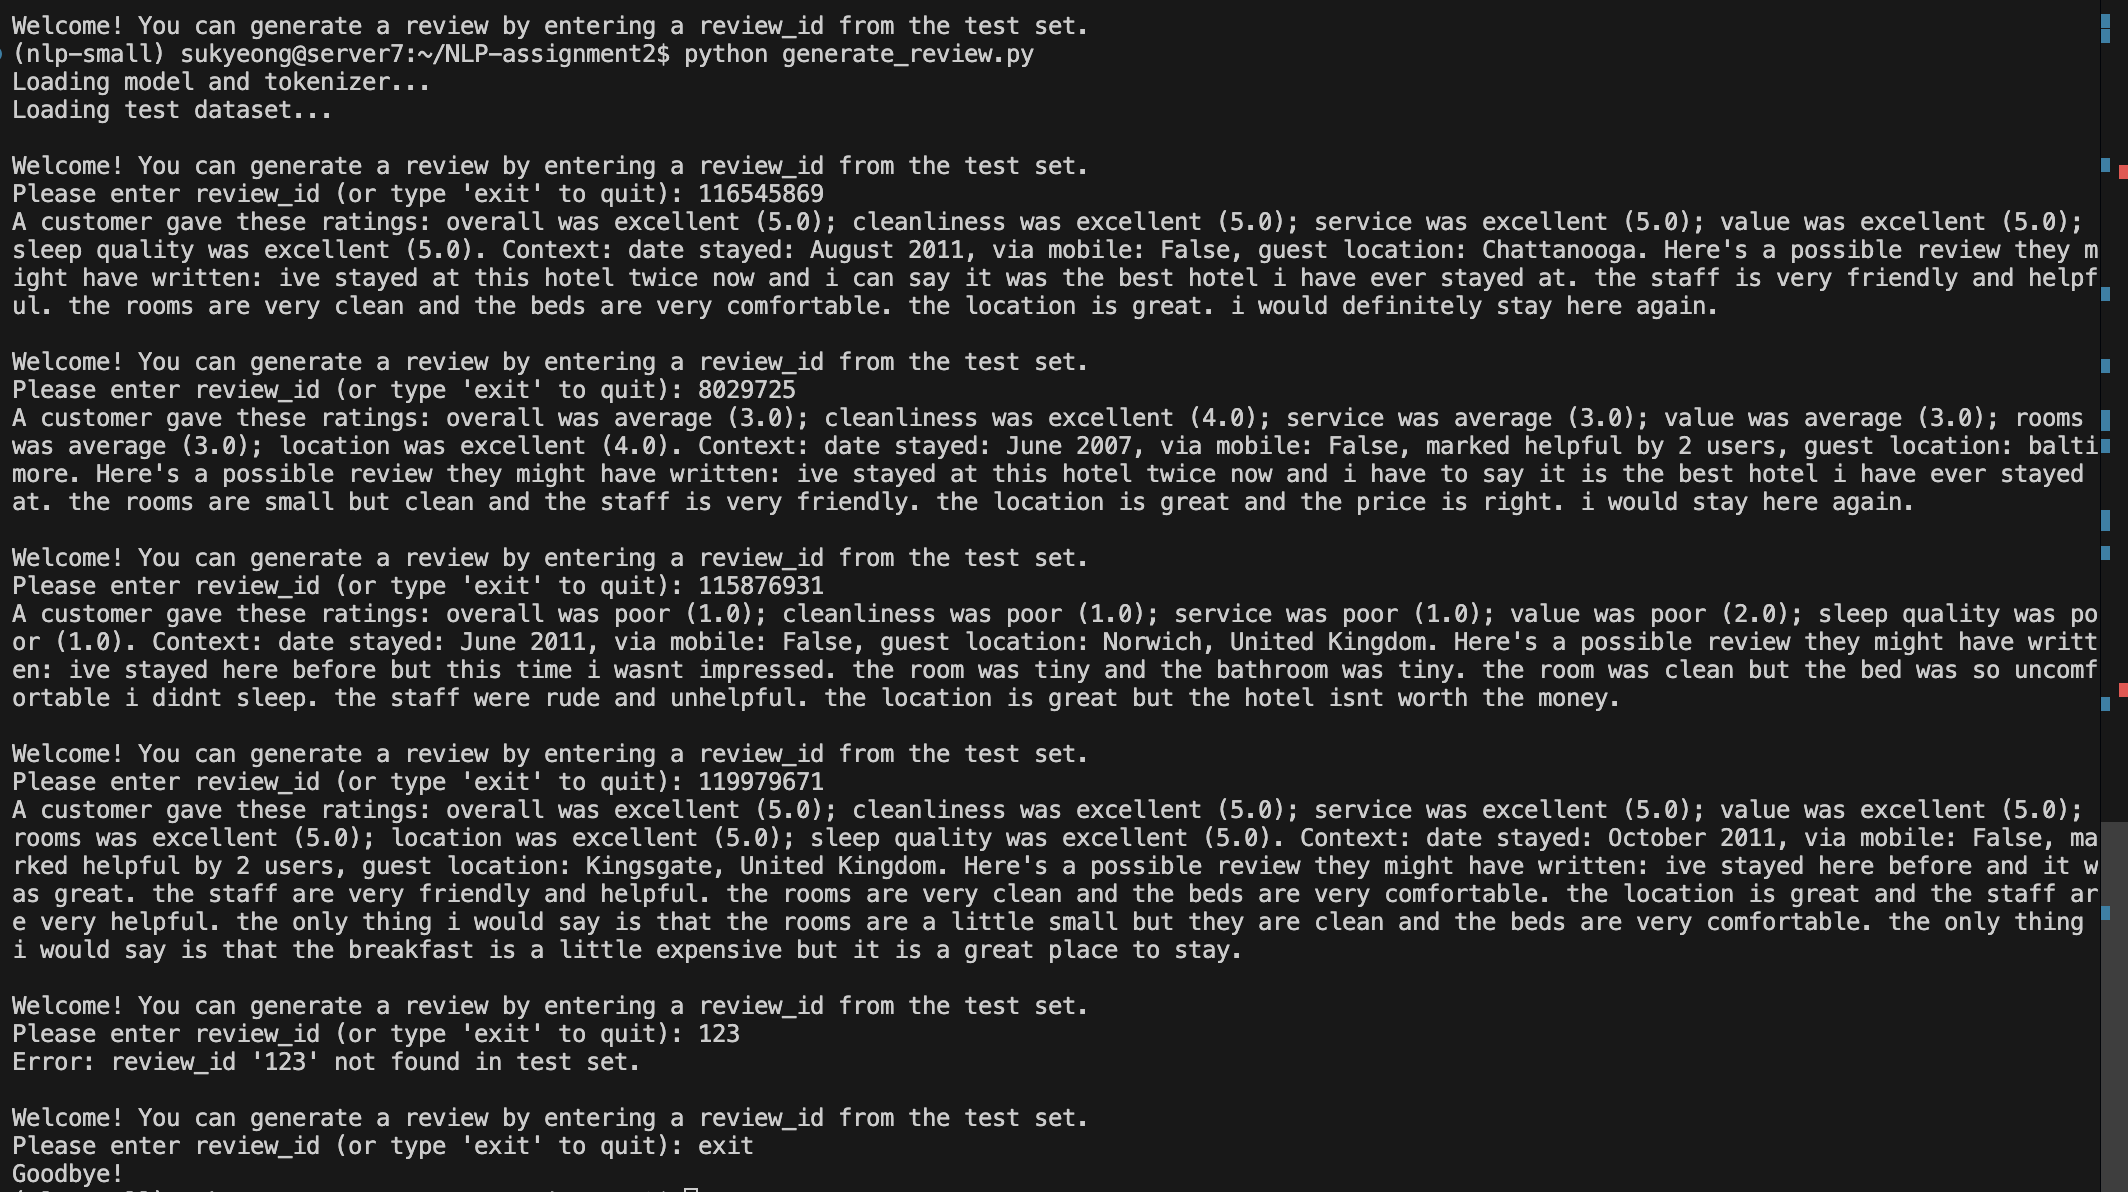

In [2]:
from IPython.display import Image
Image("User_interface_example.png")
